# Deep embedded clustering

## Library and module imports 

In [17]:
#standard libraries 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns

# Deep learning libraries
import torch 
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.utils import Bunch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from torch.utils.data import DataLoader, TensorDataset

In [18]:
# import modules from utils 

import sys
import os

# Dynamically add the 'utils' folder to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../source/')))

# Now, you can import the functions
from utils.autoencoder import Autoencoder

## Importing Covariates dataframe

In [19]:
Covariates_df = pd.read_csv("../../data/cleaned_data/Covariates.csv")
Covariates_df.head()

MunicipalityNumber    MunicipalityName  \
0                 1.0     Aeugst am Albis   
1                 2.0  Affoltern am Albis   
2                 3.0          Bonstetten   
3                 4.0     Hausen am Albis   
4                 5.0            Hedingen   

                                         urban_typo  \
0          Low-density peri-urban municipality (23)   
1  Urban municipality in a large agglomeration (11)   
2       Medium-density peri-urban municipality (22)   
3       Medium-density peri-urban municipality (22)   
4  Urban municipality in a large agglomeration (11)   

                     mountain_type                        mountain_binary  \
0  Moyen-pays - Rhin supérieur (1)  Communes hors des régions de montagne   
1  Moyen-pays - Rhin supérieur (1)  Communes hors des régions de montagne   
2  Moyen-pays - Rhin supérieur (1)  Communes hors des régions de montagne   
3  Moyen-pays - Rhin supérieur (1)  Communes hors des régions de montagne   
4  Moyen-pays - Rhin supérieur (1)  Communes hors des régions de montagne   

   Population language  Canton  Yes [nbr]  No [nbr]  ...  \
0      1998.0   german  Zürich      444.0     335.0  ...   
1     12859.0   german  Zürich     1884.0    1260.0  ...   
2      5678.0   german  Zürich     1197.0     706.0  ...   
3      3974.0   german  Zürich      764.0     555.0  ...   
4      3963.0   german  Zürich      809.0     580.0  ...   

   elec_consumption_mwh_per_year_per_capita  elec_consumption_mwh_per_year  \
0                                    4.4623                           8905   
1                                    4.1840                          53420   
2                                    2.8006                          15857   
3                                    3.9176                          15545   
4                                    5.3155                          20941   

                         elec_network_operator  mean_price (cts/kWh)  \
0  Elektrizitätswerke des Kantons Zürich (EKZ)             26.231762   
1  Elektrizitätswerke des Kantons Zürich (EKZ)             26.231762   
2  Elektrizitätswerke des Kantons Zürich (EKZ)             26.231762   
3  Elektrizitätswerke des Kantons Zürich (EKZ)             26.231762   
4  Elektrizitätswerke des Kantons Zürich (EKZ)             26.231762   

   std_price (cts/kWh)  building_new_age  building_medium_age  \
0             2.464933             998.0               4214.0   
1             2.464933            2145.0              13437.0   
2             2.464933            1404.0              10038.0   
3             2.464933            1325.0               7134.0   
4             2.464933            1219.0               5530.0   

   building_old_age  share of people in individual households  new business  
0            2414.0                                     0.493           9.0  
1           11173.0                                     0.209          41.0  
2            3904.0                                     0.354          21.0  
3            6261.0                                     0.474          16.0  
4            5243.0                                     0.432          14.0  

[5 rows x 45 columns]

## Transforming dataframe

### Transforming categorical columns into integer columns

In [20]:
print("transforming dataframe...")
# Identify categorical columns
categorical_columns = Covariates_df.select_dtypes(include=['object', 'string']).columns
categorical_columns = categorical_columns.drop(["MunicipalityName", "mountain_binary"])
print(categorical_columns)

# Apply encoding only to categorical columns
encoded_categorical = pd.get_dummies(Covariates_df[categorical_columns])
#print(encoded_categorical)

# Concatenate with untouched columns
non_categorical = Covariates_df.drop(columns=categorical_columns)
non_categorical = Covariates_df.drop(columns=["MunicipalityName", "MunicipalityNumber", "mountain_binary"])
transformed_df = pd.concat([non_categorical, encoded_categorical.astype(int)], axis=1).drop(columns=categorical_columns)

print("Transformed DataFrame:")
#print(transformed_df.dtypes) # Display the data types of each column
transformed_df[["elec_consumption_households_mwh_per_year", "elec_consumption_mwh_per_year"]]=transformed_df[["elec_consumption_households_mwh_per_year", "elec_consumption_mwh_per_year"]].astype(float)
print("data type of the modified elec columns:\n", transformed_df[["elec_consumption_households_mwh_per_year", "elec_consumption_mwh_per_year"]].dtypes)
transformed_df.to_csv("../../data/cleaned_data/numeric_covariates.csv")
for col in transformed_df.columns:
    print(transformed_df[col].dtypes)

transforming dataframe...
Index(['urban_typo', 'mountain_type', 'language', 'Canton',
       'elec_network_operator'],
      dtype='object')
Transformed DataFrame:
data type of the modified elec columns:
 elec_consumption_households_mwh_per_year    float64
elec_consumption_mwh_per_year               float64
dtype: object


float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
float64
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
int32
in

### relative percentages of political parties

In [21]:
transformed_political_df = transformed_df.copy()

political_columns = ["PLR", "PDC", "PS", "UDC", "PEV/PCS", "PVL", "PBD", "PST/Sol.", "Small right-wing parties"]
economic_sectors = ["Primary sector", "Secondary sector", "Tertiary sector"]
ages_columns = ["0-19 years", "20-64 years","65 years or older"]
votes_columns = ["Yes [nbr]", "No [nbr]"]
building_age_column = ["building_new_age","building_medium_age","building_old_age"]
business_column = ["new business"]

In [22]:
transformed_political_df["Private households"]

0        848.0
1       5412.0
2       2327.0
3       1552.0
4       1580.0
         ...  
2126     585.0
2127     504.0
2128     497.0
2129     159.0
2130     389.0
Name: Private households, Length: 2131, dtype: float64

In [23]:
initial_political_sum = transformed_political_df[political_columns].sum(axis=1)
initial_economic_sector_sum = transformed_political_df[economic_sectors].sum(axis=1)
ages_sum = transformed_political_df[ages_columns].sum(axis=1)
votes_sum = transformed_political_df[votes_columns].sum(axis=1)

for col in political_columns:
    transformed_political_df[col]= transformed_political_df[col]/initial_political_sum

for col in economic_sectors:
    transformed_political_df[col]= transformed_political_df[col]/initial_economic_sector_sum
    
for col in ages_columns:
    transformed_political_df[col]= transformed_political_df[col]/ages_sum

for col in votes_columns:
    transformed_political_df[col]= transformed_political_df[col]/votes_sum

#normalizing private households 
transformed_political_df["Private households"] = transformed_political_df["Private households"]/transformed_political_df["Population"]

#normalizing buildings 
for col in building_age_column: 
    transformed_political_df[col]= transformed_political_df[col]/transformed_political_df["Population"]

# Normalizing business
transformed_political_df["new business"] = transformed_political_df["new business"]/transformed_political_df["Population"]


print(transformed_political_df[political_columns].sum(axis=1))
print(transformed_political_df[economic_sectors].sum(axis=1))
print(transformed_political_df[ages_columns].sum(axis=1))
print(transformed_political_df[votes_columns].sum(axis=1))
print(transformed_political_df[business_column].sum(axis=1))


0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2126    1.0
2127    1.0
2128    1.0
2129    1.0
2130    1.0
Length: 2131, dtype: float64
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2126    1.0
2127    1.0
2128    1.0
2129    1.0
2130    1.0
Length: 2131, dtype: float64
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2126    1.0
2127    1.0
2128    1.0
2129    1.0
2130    1.0
Length: 2131, dtype: float64
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
2126    1.0
2127    1.0
2128    1.0
2129    1.0
2130    1.0
Length: 2131, dtype: float64
0       0.004505
1       0.003188
2       0.003698
3       0.004026
4       0.003533
          ...   
2126    0.000000
2127    0.000000
2128    0.000000
2129    0.000000
2130    0.006519
Length: 2131, dtype: float64


In [24]:
transformed_political_df["Private households"]

0       0.424424
1       0.420873
2       0.409827
3       0.390539
4       0.398688
          ...   
2126    0.452087
2127    0.476821
2128    0.438272
2129    0.438017
2130    0.507171
Name: Private households, Length: 2131, dtype: float64

In [25]:
transformed_political_df[building_age_column]

building_new_age  building_medium_age  building_old_age
0             0.499499             2.109109          1.208208
1             0.166809             1.044949          0.868886
2             0.247270             1.767876          0.687566
3             0.333417             1.795169          1.575491
4             0.307595             1.395408          1.322988
...                ...                  ...               ...
2126          0.306028             1.382535          5.459042
2127          0.332072             2.101230          4.882687
2128          0.320988             1.748677          4.649912
2129          0.413223             1.735537          4.388430
2130               NaN                  NaN               NaN

[2131 rows x 3 columns]

## Removing NANs and estimating missing values

In [26]:
# Verifying that Nan values have correctly been removed
print(transformed_political_df.isna().sum())  # Inspect the first few rows

print(transformed_political_df.isna().any(axis=1).sum())  # take a look at each row at once
correctable_columns = transformed_political_df.columns.drop(
    [
    "PLR", 
    "PDC", 
    "PS", 
    "UDC", 
    "PEV/PCS", 
    "PVL", 
    "PBD", 
    "PST/Sol.", 
    "PES", 
    "Small right-wing parties", 
    "Primary sector", 
    "Secondary sector", 
    "Tertiary sector", 
    ]
)
processed_transformed_df = transformed_political_df.copy()
for column in correctable_columns:
    processed_transformed_df[column] = processed_transformed_df[column].fillna(processed_transformed_df[column].mean())


processed_transformed_df = processed_transformed_df.apply(pd.to_numeric, errors='coerce').fillna(0) # in case their are NANs remaining
print(processed_transformed_df.isna().sum())  # Inspect the first few rows


Population                                                   1
Yes [nbr]                                                    5
No [nbr]                                                     5
0-19 years                                                   1
20-64 years                                                  1
                                                            ..
elec_network_operator_eug Elektra Untergäu Genossenschaft    0
elec_network_operator_ewl Kabelnetz AG                       0
elec_network_operator_genossenschaft elektra busslingen      0
elec_network_operator_rwt Regionalwerk Toggenburg AG         0
elec_network_operator_tba energie ag                         0
Length: 560, dtype: int64
1788
Population                                                   0
Yes [nbr]                                                    0
No [nbr]                                                     0
0-19 years                                                   0
20-64 years             

In [27]:
processed_transformed_df[political_columns].sample(5)

PLR       PDC        PS       UDC   PEV/PCS       PVL       PBD  \
1871  0.214310  0.030232  0.293920  0.249244  0.025529  0.077595  0.018475   
1064  0.109360  0.308539  0.073727  0.407061  0.005090  0.077340  0.016749   
1753  0.371608  0.097077  0.083507  0.195198  0.026096  0.189979  0.012526   
1113  0.082713  0.325889  0.162945  0.247312  0.000000  0.088503  0.092639   
644   0.000000  0.000000  0.325516  0.000000  0.000000  0.000000  0.674484   

      PST/Sol.  Small right-wing parties  
1871  0.049714                  0.040981  
1064  0.000000                  0.002135  
1753  0.022965                  0.001044  
1113  0.000000                  0.000000  
644   0.000000                  0.000000

## Scaling the dataframe

In [28]:
# Creating a copy of the dataframe
scaled_processed_transformed_df = processed_transformed_df.copy()

# Step 1: Identify continuous variables
# Let's assume continuous variables are of float type. You can adjust this based on your dataset.
continuous_columns = scaled_processed_transformed_df.select_dtypes(include=['float64']).columns
print(scaled_processed_transformed_df[continuous_columns].max())
# Step 2: Scale only continuous variables
scaler = StandardScaler()

# Scale only the continuous columns
scaled_processed_transformed_df[continuous_columns] = scaler.fit_transform(scaled_processed_transformed_df[continuous_columns])
scaled_processed_transformed_df.to_csv("../../data/cleaned_data/calculable_covariates.csv")
scaled_processed_transformed_df.sample(5)

Population                                             4.339890e+05
Yes [nbr]                                              8.235294e-01
No [nbr]                                               9.250000e-01
0-19 years                                             3.720930e-01
20-64 years                                            8.108108e-01
65 years or older                                      4.030683e-01
Private households                                     6.842105e-01
Housing and infrastructure area (%)                    2.604189e+04
Total employment                                       4.911930e+05
Primary sector                                         1.000000e+00
Secondary sector                                       9.547018e-01
Tertiary sector                                        1.000000e+00
New housing units built per 1000 inhabitants           9.601182e+01
Social assistance rate                                 1.878370e+04
PLR                                             

Population  Yes [nbr]  No [nbr]  0-19 years  20-64 years  \
0      -0.164167   0.489165 -0.489165   -0.207587     0.645798   
630     0.489594  -0.371991  0.371991   -0.497131    -0.216833   
1565   -0.100017   0.423569 -0.423569   -1.405103    -0.423704   
830     0.210415  -0.050745  0.050745   -0.693757     0.844982   
1258    0.294452  -1.013789  1.013789    0.485397     1.000945   

      65 years or older  Private households  \
0             -0.307013            0.314385   
630            0.534425            0.261412   
1565           1.374316            1.074621   
830           -0.080466            0.207744   
1258          -1.090065           -0.558514   

      Housing and infrastructure area (%)  Total employment  Primary sector  \
0                               -0.120694         -0.150143       -0.427424   
630                             -0.075876          0.433613       -0.697697   
1565                             0.000272         -0.113979       -0.837277   
830                              0.104074         -0.040711       -0.892055   
1258                             0.047859          0.097651       -0.846960   

      ...  elec_network_operator_Werke am Zürichsee AG (Zollikon)  \
0     ...                                                  0        
630   ...                                                  0        
1565  ...                                                  0        
830   ...                                                  0        
1258  ...                                                  0        

      elec_network_operator_die werke versorgung wallisellen ag  \
0                                                     0           
630                                                   0           
1565                                                  0           
830                                                   0           
1258                                                  0           

      elec_network_operator_ebs Energie AG  \
0                                        0   
630                                      0   
1565                                     0   
830                                      0   
1258                                     0   

      elec_network_operator_endigo Holding AG  \
0                                           0   
630                                         0   
1565                                        0   
830                                         0   
1258                                        0   

      elec_network_operator_energia alpina  \
0                                        0   
630                                      0   
1565                                     0   
830                                      0   
1258                                     0   

      elec_network_operator_eug Elektra Untergäu Genossenschaft  \
0                                                     0           
630                                                   0           
1565                                                  0           
830                                                   0           
1258                                                  0           

      elec_network_operator_ewl Kabelnetz AG  \
0                                          0   
630                                        0   
1565                                       0   
830                                        0   
1258                                       0   

      elec_network_operator_genossenschaft elektra busslingen  \
0                                                     0         
630                                                   0         
1565                                                  0         
830                                                   0         
1258                                                  0         

      elec_network_operator_rwt Regionalwerk Toggenburg AG  \
0                                      

## Clarifying columnn names

In [29]:

scaled_processed_transformed_df.columns

Index(['Population', 'Yes [nbr]', 'No [nbr]', '0-19 years', '20-64 years',
       '65 years or older', 'Private households',
       'Housing and infrastructure area (%)', 'Total employment',
       'Primary sector',
       ...
       'elec_network_operator_Werke am Zürichsee AG (Zollikon)',
       'elec_network_operator_die werke versorgung wallisellen ag',
       'elec_network_operator_ebs Energie AG',
       'elec_network_operator_endigo Holding AG',
       'elec_network_operator_energia alpina',
       'elec_network_operator_eug Elektra Untergäu Genossenschaft',
       'elec_network_operator_ewl Kabelnetz AG',
       'elec_network_operator_genossenschaft elektra busslingen',
       'elec_network_operator_rwt Regionalwerk Toggenburg AG',
       'elec_network_operator_tba energie ag'],
      dtype='object', length=560)

In [30]:
"""scaled_processed_transformed_df.columns = ['Population', 'Yes to climate and innovation act', 'No to climate and innovation act', '0-19 year-olds', '20-64 year-olds',
       '65 year-olds or older', 'Private households',
       'Housing and infrastructure area (%)', 'Total employment',
       'Primary sector', 'Secondary sector', 'Tertiary sector',
       'New housing units built per 1000 inhabitants',
       'Social assistance rate', "Free Democratic Party(FDP)","Christian Democratic People's Party (CVP/PDC)","Social Democratic Party (SPS/PS)",
       "Swiss People's Party (SVP/UDC)",
       "Evangelical People's Party (EVP/PEV) / Christian Social Party (CSP/PCS)",
       "Green Liberal Party (GLP/PVL)",
       "Conservative Democratic Party (BDP/PBD)",
       "Swiss Labour Party (PST/POP) / Solidarity (Sol.)",
       "Ecologist Party (PES)",
       "Small right-wing parties",
       'Municipal_rev [CHF]', 'revenue_per_capita [CHF]',
       'elec_consumption_households_mwh_per_year_per_capita',
       'elec_consumption_households_mwh_per_year',
       'elec_consumption_mwh_per_year_per_capita',
       'elec_consumption_mwh_per_year', 'mean_price (cts/kWh)',
       'std_price (cts/kWh)', 'new_buildings_per_capita', 'old_buildings_per_capita',
       'ancient_buildings_per_capita',
       'Centrally located rural municipality',
       'High-density peri-urban municipality',
       'Low-density peri-urban municipality',
       'Medium-density peri-urban municipality',
       'Peripheral rural municipality',
       'Rural center municipality',
       'Urban municipality in a large agglomeration',
       'Urban municipality in a medium-sized agglomeration',
       'Urban municipality in a small or non-agglomerated area',
       'Alpes',
       'black_forest-jura_souabe', 'jura',
       'middle land - Rhein',
       'non_mountainous', 'french',
       'german', 'italian', 'romansh']"""

'scaled_processed_transformed_df.columns = [\'Population\', \'Yes to climate and innovation act\', \'No to climate and innovation act\', \'0-19 year-olds\', \'20-64 year-olds\',\n       \'65 year-olds or older\', \'Private households\',\n       \'Housing and infrastructure area (%)\', \'Total employment\',\n       \'Primary sector\', \'Secondary sector\', \'Tertiary sector\',\n       \'New housing units built per 1000 inhabitants\',\n       \'Social assistance rate\', "Free Democratic Party(FDP)","Christian Democratic People\'s Party (CVP/PDC)","Social Democratic Party (SPS/PS)",\n       "Swiss People\'s Party (SVP/UDC)",\n       "Evangelical People\'s Party (EVP/PEV) / Christian Social Party (CSP/PCS)",\n       "Green Liberal Party (GLP/PVL)",\n       "Conservative Democratic Party (BDP/PBD)",\n       "Swiss Labour Party (PST/POP) / Solidarity (Sol.)",\n       "Ecologist Party (PES)",\n       "Small right-wing parties",\n       \'Municipal_rev [CHF]\', \'revenue_per_capita [CHF]\',\n 

## Checking for relationship types between covariates (non linear and linear)

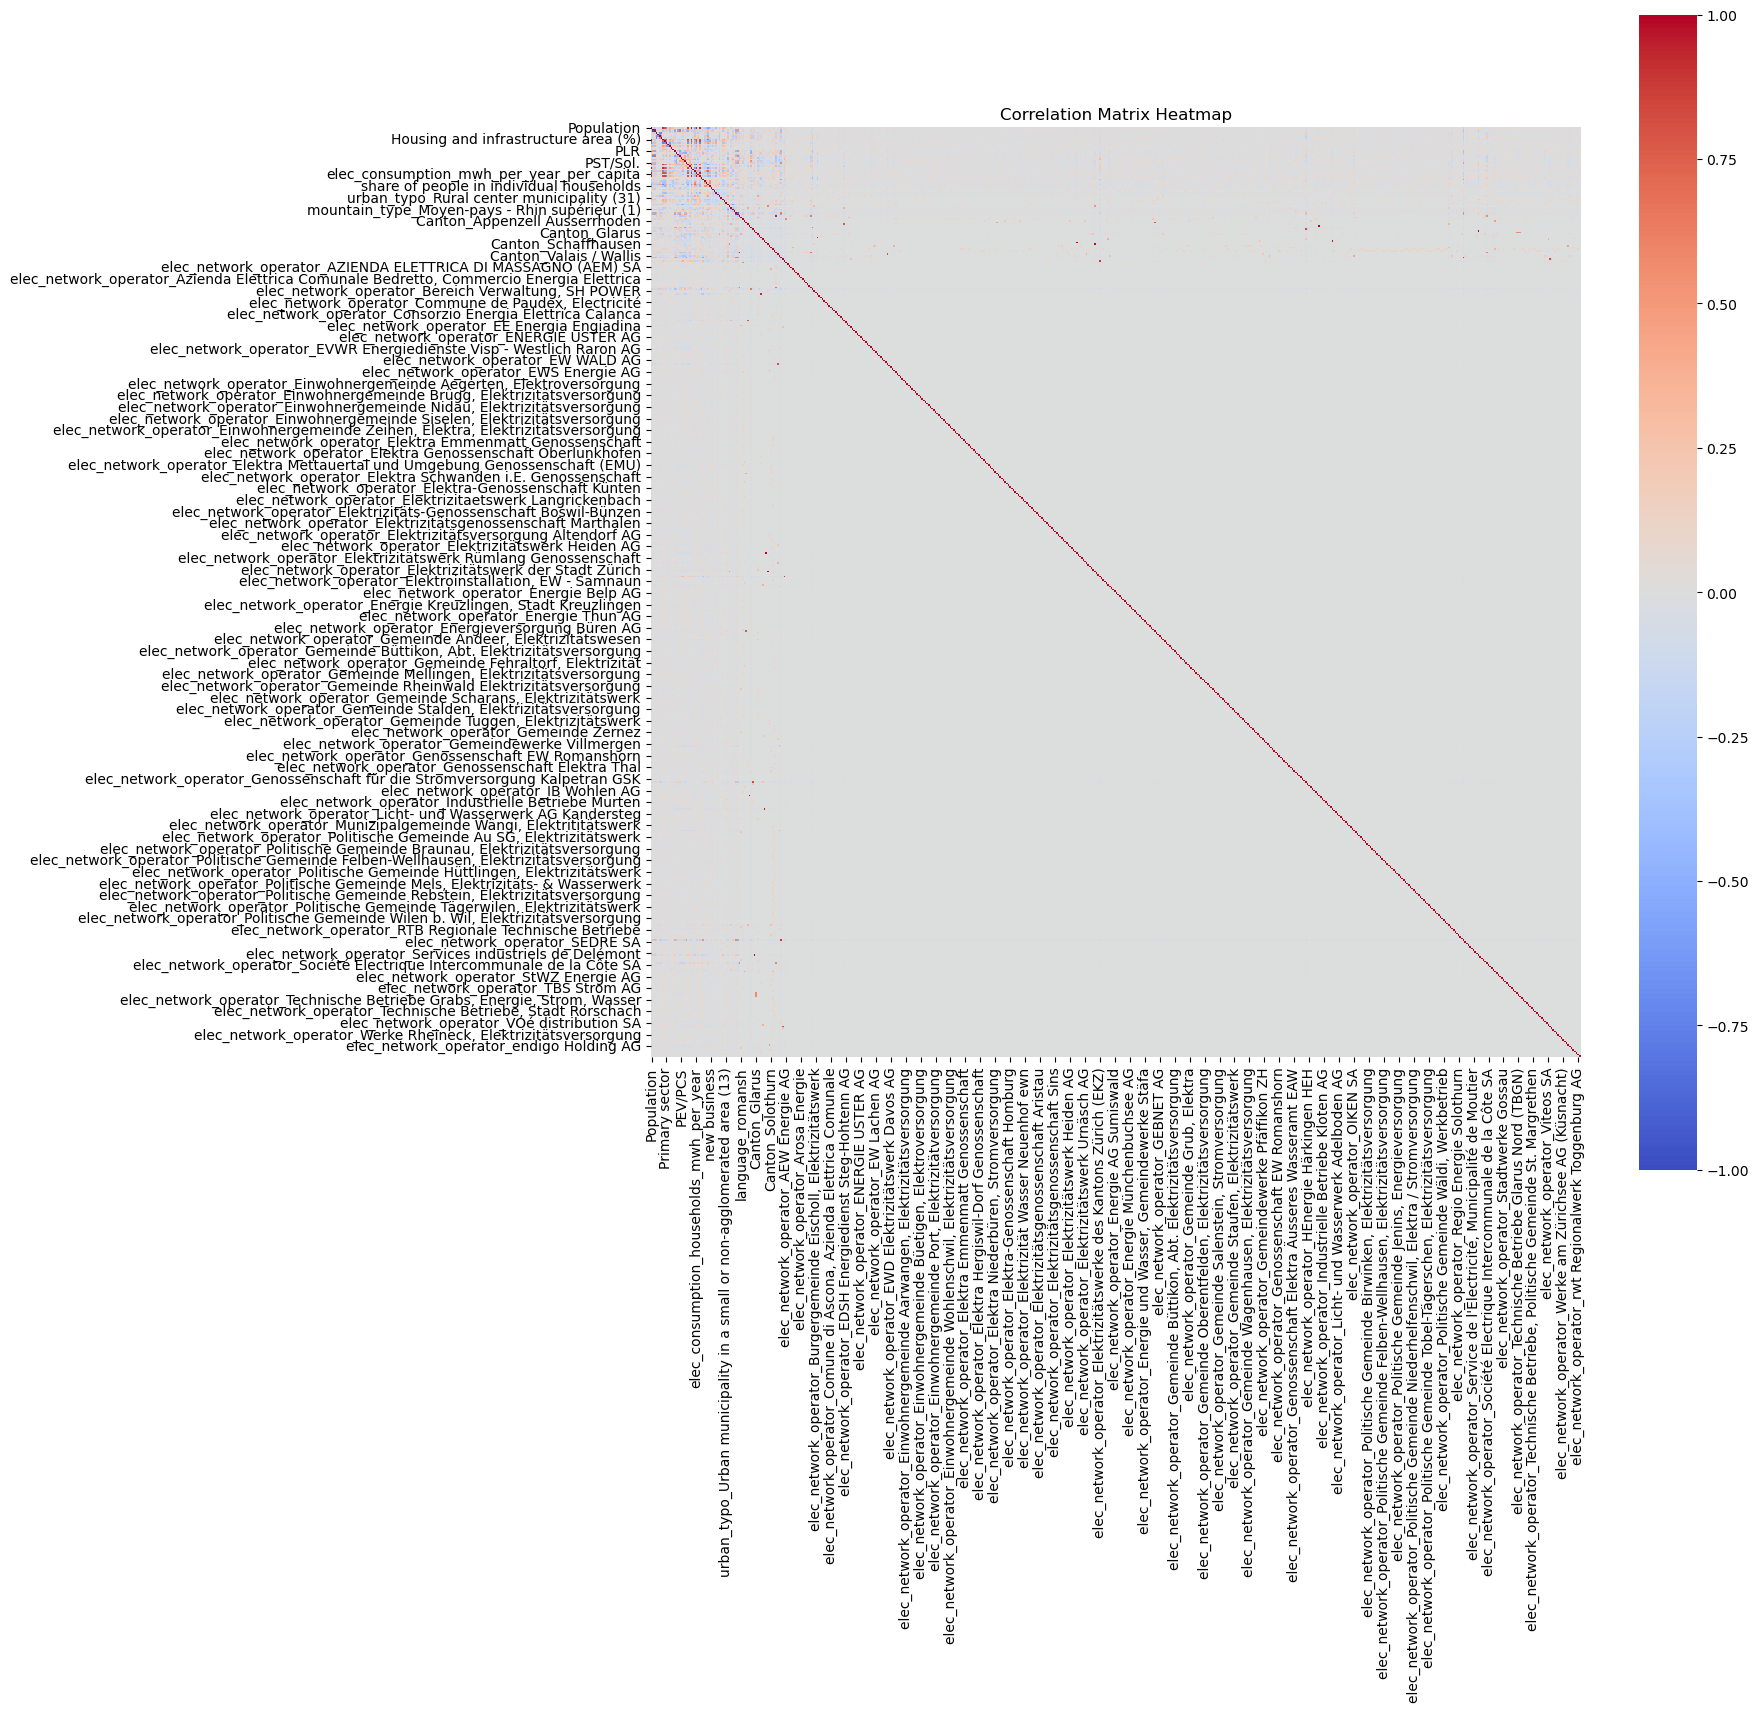

In [31]:
# Spearman's correlaiton coefficient 
correlation_matrix = scaled_processed_transformed_df.corr(method='spearman')

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 15))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()


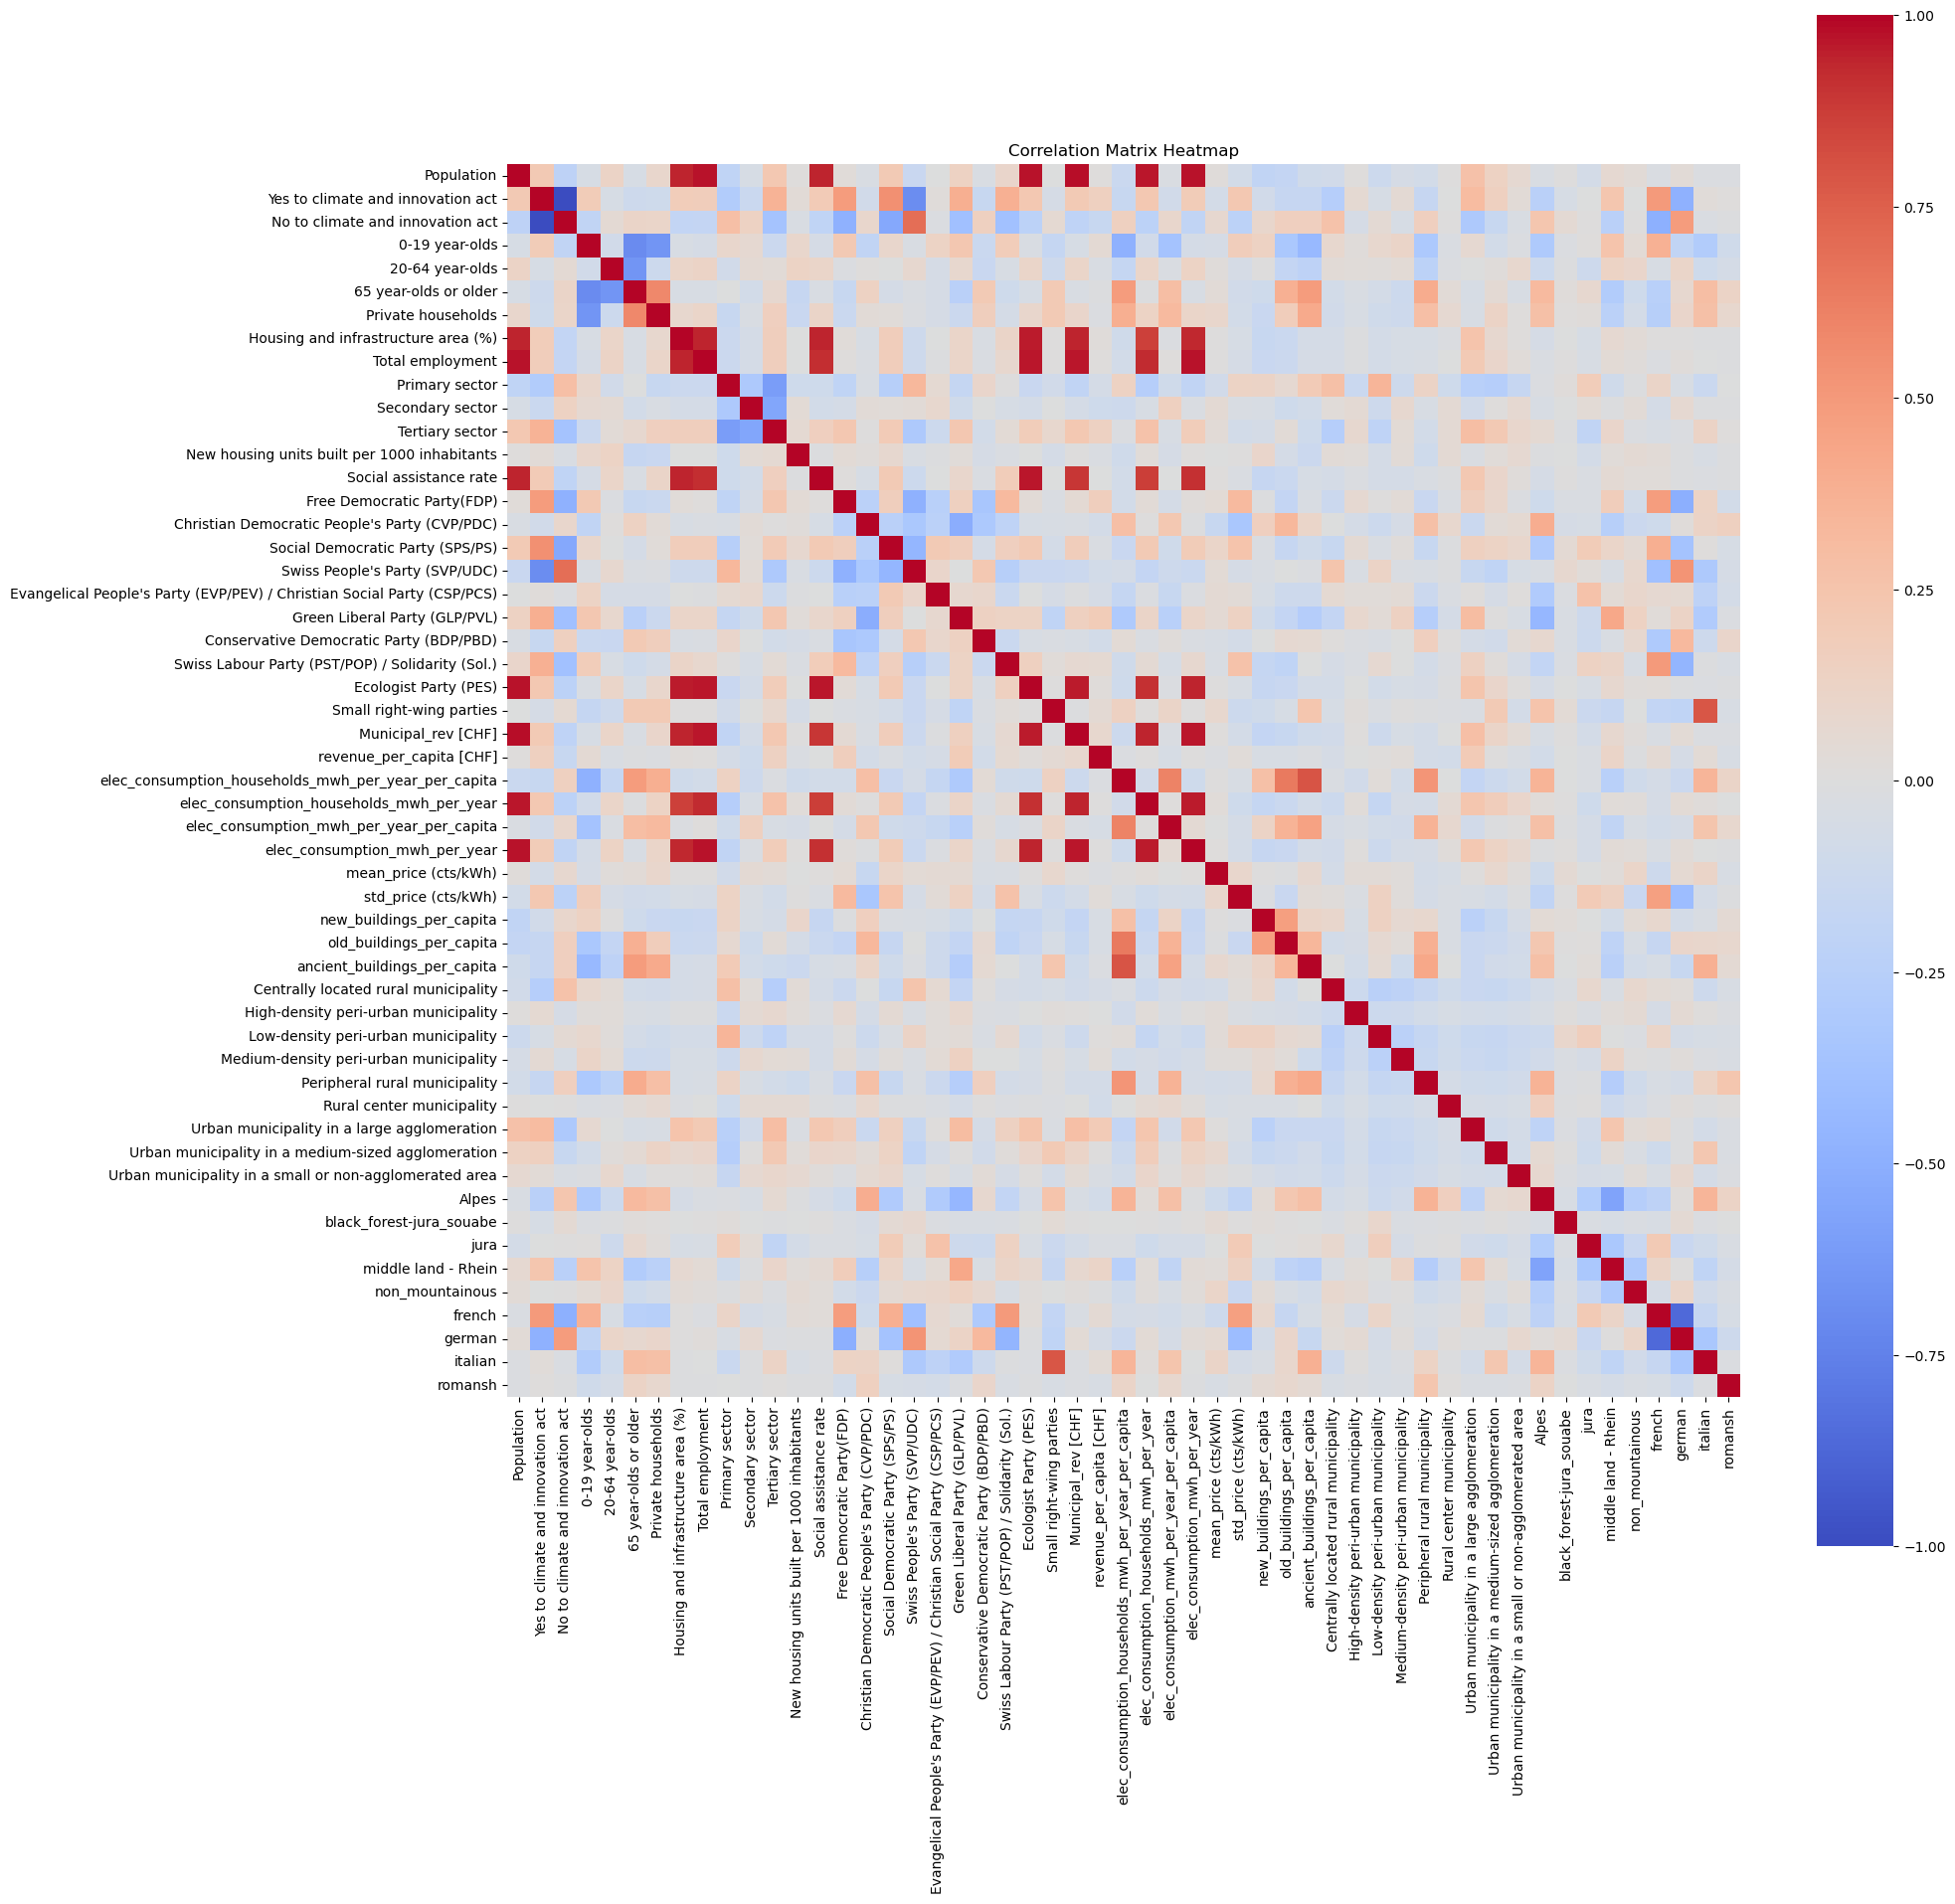

In [16]:
# Pearson's correlaiton coefficient 
correlation_matrix = scaled_processed_transformed_df.corr(method='pearson')

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(20, 20))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

The data seems to hold non linear relationships > which leads us to applying deep embedded clusteing coupled to DBSCAN rather than PCA Analysis with K-means clustering

## Model definition

### Defintion of a simple model

In [32]:
# copying dataframe
df = scaled_processed_transformed_df.copy()

# Step 4: Define the Autoencoder Model using PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder part
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim)  # Latent space representation
        )
        
        # Decoder part
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Output layer with sigmoid activation
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Returns the encoded (latent) representation of the input"""
        return self.encoder(x)

# Step 5: Prepare data for PyTorch (convert to tensors)
X_tensor = torch.tensor(df.values, dtype=torch.float32)

# Step 6: Instantiate the Autoencoder
input_dim = df.shape[1]
print(f"\nInput dim : {input_dim}\n")
encoding_dim = 3 # Latent space dimension (you can change this)
autoencoder = Autoencoder(input_dim, encoding_dim)

# Step 7: Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Step 8: Train the Autoencoder
epochs = 100
batch_size = 16
dataset = TensorDataset(X_tensor, X_tensor)  # Input and output are the same for autoencoder
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Running Neural network...")
for epoch in range(epochs):
    for data in dataloader:
        inputs, _ = data  # We don't need the output, as we are using the input itself
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Step 9: Get the Encoded (Latent) Features
X_encoded = autoencoder.encode(X_tensor).detach().numpy()

np.savetxt('../../data/cleaned_data/X_encoded_simple.csv', X_encoded, delimiter=',')

print("\nModel trained!")



Input dim : 560

Running Neural network...
Epoch [10/100], Loss: 0.0329
Epoch [20/100], Loss: 0.0317
Epoch [30/100], Loss: 0.0427
Epoch [40/100], Loss: 0.0484
Epoch [50/100], Loss: 0.0192
Epoch [60/100], Loss: 0.0422
Epoch [70/100], Loss: 0.0373
Epoch [80/100], Loss: 0.0279
Epoch [90/100], Loss: 0.0420
Epoch [100/100], Loss: 0.0349

Model trained!


### Defintion of a more complex model

In [18]:
# Assuming you have a DataFrame of covariates called df
df = scaled_processed_transformed_df.copy()

# Step 3: Define the Autoencoder Model using PyTorch
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder with Batch Normalization and Dropout
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Linear(16, encoding_dim)  # Latent space representation
        )
        
        # Decoder with Batch Normalization and Dropout
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(0.2),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, input_dim),
            nn.Sigmoid()  # Output layer with sigmoid activation
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """Returns the encoded (latent) representation of the input"""
        return self.encoder(x)

# Step 4: Prepare data for PyTorch (convert to tensors)
X_tensor = torch.tensor(df.values, dtype=torch.float32)

# Step 5: Instantiate the Autoencoder
input_dim = df.shape[1]  # Number of features in the dataset
encoding_dim = 4  # Increased latent space dimension
autoencoder = Autoencoder(input_dim, encoding_dim)

# Step 6: Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for reconstruction
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Step 7: Train the Autoencoder
epochs = 100 #originally 100
batch_size = 8 # originally 16
dataset = TensorDataset(X_tensor, X_tensor)  # Input and output are the same for autoencoder
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Running Neural network...")
for epoch in range(epochs):
    for data in dataloader:
        inputs, _ = data  # We don't need the output, as we are using the input itself
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Step 8: Get the Encoded (Latent) Features
X_encoded = autoencoder.encode(X_tensor).detach().numpy()

# Save the array to a CSV file
np.savetxt('../../data/cleaned_data/X_encoded.csv', X_encoded, delimiter=',')

print("\nModel trained !")


Running Neural network...
Epoch [10/100], Loss: 0.4938
Epoch [20/100], Loss: 0.3742
Epoch [30/100], Loss: 0.3183
Epoch [40/100], Loss: 0.2693
Epoch [50/100], Loss: 0.2345
Epoch [60/100], Loss: 0.4794
Epoch [70/100], Loss: 0.3988
Epoch [80/100], Loss: 0.6370
Epoch [90/100], Loss: 0.3233
Epoch [100/100], Loss: 0.4258

Model trained !


## Analyzing latent space

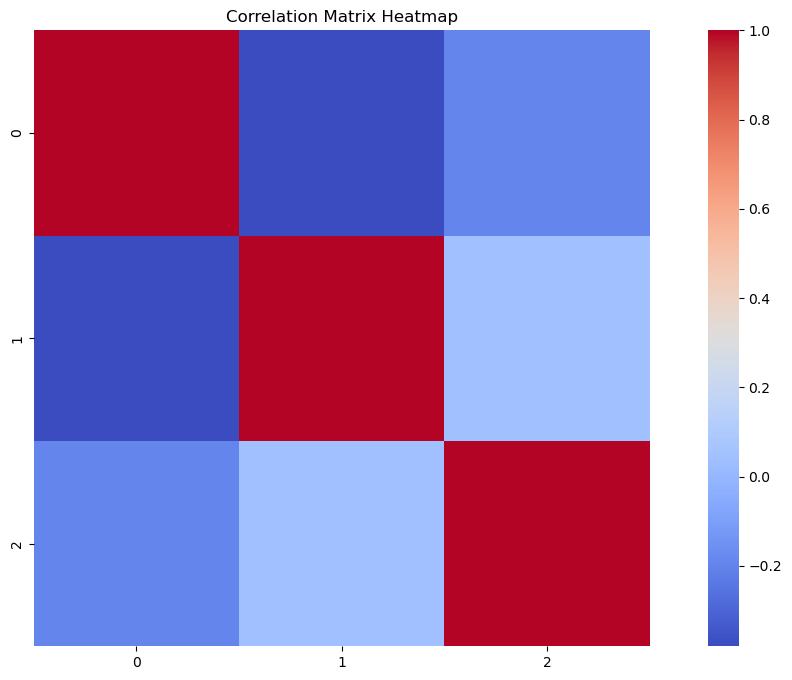

In [33]:
# Spearman's correlaiton coefficient 
correlation_matrix = np.corrcoef(X_encoded, rowvar=False)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(15, 8))  # Set the size of the plot
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

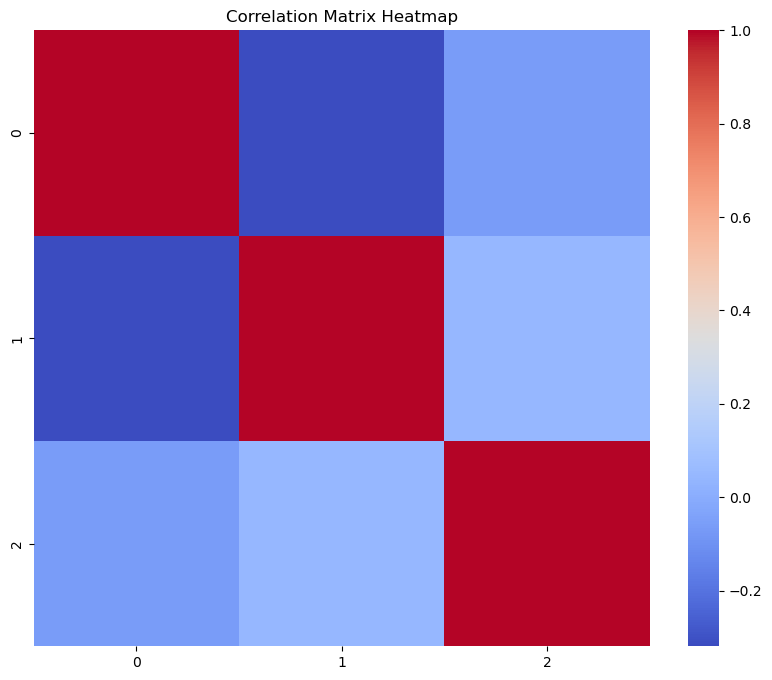

In [34]:
from scipy.stats import spearmanr

# Calculate the Spearman correlation matrix
corr, _ = spearmanr(X_encoded, axis=0)

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))  # Set the size of the plot
sns.heatmap(corr, annot=False, cmap='coolwarm', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

## DBSCAN clustering

ep: 0.01
ms: 2
[-1  0]
ms: 3
[-1  0]
ms: 4
[-1  0]
ms: 5
[-1  0]
ms: 6
[-1  0]
ms: 7
[-1  0]
ms: 8
[-1  0]
ms: 9
[-1  0]
ms: 10
[-1  0]
ms: 11
[-1  0]
ms: 12
[-1  0]
ms: 13
[-1]
ms: 14
[-1]
ep: 0.09777777777777778
ms: 2
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
ms: 3
[-1  0  1  2]
ms: 4
[-1  0  1]
ms: 5
[-1  0]
ms: 6
[-1  0]
ms: 7
[-1  0]
ms: 8
[-1  0]
ms: 9
[-1  0]
ms: 10
[-1  0]
ms: 11
[-1  0]
ms: 12
[-1  0]
ms: 13
[-1  0]
ms: 14
[-1  0]
ep: 0.18555555555555558
ms: 2
[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120

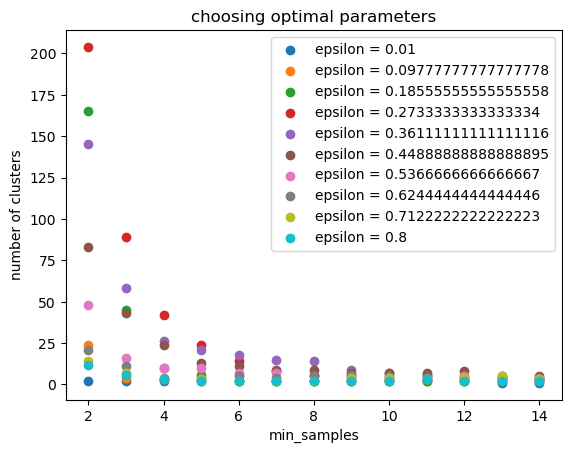

In [21]:
eps = np.linspace(0.01, 0.8, 10)
min_samples_array = np.arange(2, 15, 1)

for ep in eps:
    print("ep:", ep)
    clust_number_list = []
    for ms in min_samples_array:
        
        print("ms:", ms)
        # Step 9: Apply DBSCAN to the latent space
        dbscan_algo = DBSCAN(eps=ep, min_samples=ms)  # Adjust eps and min_samples as needed
        clusters = dbscan_algo.fit_predict(X_encoded)
        print(np.unique(clusters))
        clust_number_list.append(len(np.unique(clusters)))
    plt.scatter(min_samples_array, clust_number_list, label=f"epsilon = {ep}")
plt.xlabel("min_samples")
plt.ylabel("number of clusters")
plt.legend()
plt.title("choosing optimal parameters")
plt.show()

In [22]:

# Step 9: Apply DBSCAN to the latent space
dbscan = DBSCAN(eps=0.4, min_samples=14)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(X_encoded)

# Step 10: Optionally, you can visualize the clusters or perform further evaluation
print("Cluster labels:", clusters)

Cluster labels: [-1 -1 -1 ... -1 -1 -1]


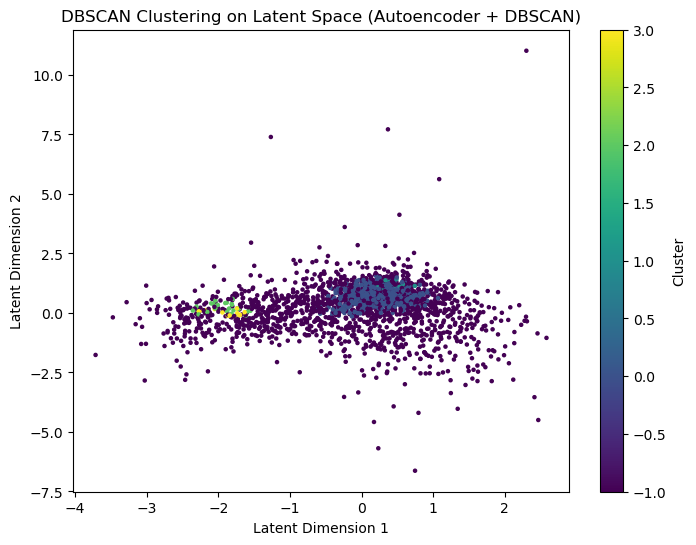

Silhouette Score: -0.25276660919189453
Davies-Bouldin Index: 2.4000290102425423
Cluster labels: [-1 -1 -1 ... -1 -1 -1]


In [23]:
# Step 11: Visualize the results
plt.figure(figsize=(8, 6))
plt.scatter(X_encoded[:, 0], X_encoded[:, 1], c=clusters, cmap='viridis', s=5)
plt.title("DBSCAN Clustering on Latent Space (Autoencoder + DBSCAN)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.colorbar(label='Cluster')
plt.show()

# Step 12: Evaluate the clustering (optional)
silhouette_avg = silhouette_score(X_encoded, clusters)
print(f"Silhouette Score: {silhouette_avg}")

db_score = davies_bouldin_score(X_encoded, clusters)
print(f"Davies-Bouldin Index: {db_score}")

# Cluster and True Labels comparison (if you have labels)
print("Cluster labels:", clusters)

## Hierchical clustering

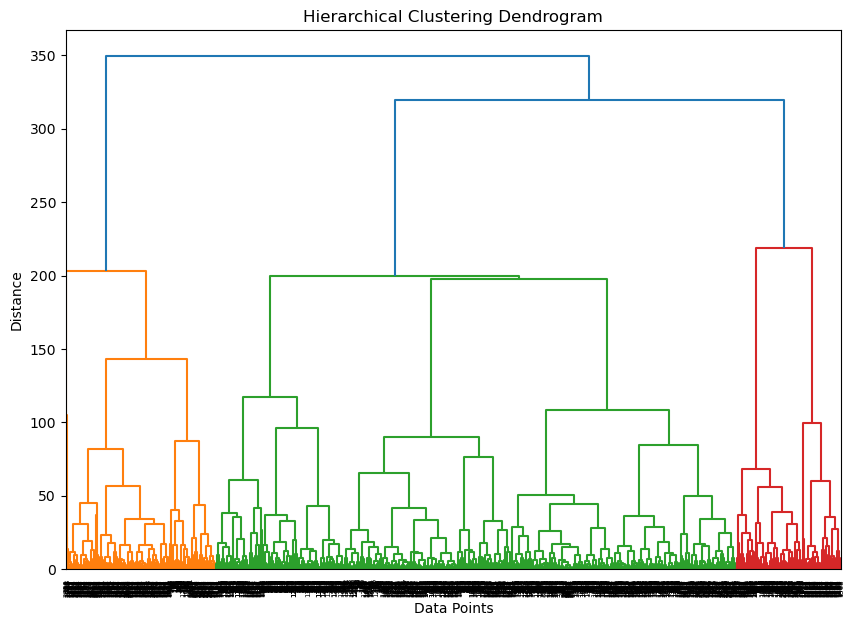

In [19]:
X_latent = np.genfromtxt("../../data/cleaned_data/X_encoded_simple_best.csv", delimiter=",")

import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Perform hierarchical/agglomerative clustering
Z = linkage(X_latent, method='ward')  # 'ward' minimizes the variance of clusters being merged

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


## K-Means Clustering

In [35]:
#X_latent = np.genfromtxt("../../data/cleaned_data/X_encoded_simple_to_keep.csv", delimiter=",")
#X_latent = np.genfromtxt("../../data/cleaned_data/X_encoded_simple_best.csv", delimiter=",")
X_latent = np.genfromtxt("../../data/cleaned_data/X_encoded.csv", delimiter=",")


In [36]:
# Number of clusters to test
number_of_clusters = np.arange(2, 21)  # Clusters from 2 to 20

# Lists to store evaluation scores
silhouette_list = []
davies_bouldin_list = []
silhouette_max=0

for num_clusters in number_of_clusters: 
    # Step 9: Apply K-Means to the latent space
    kmeans = KMeans(n_clusters=num_clusters,  init='k-means++', n_init=10, random_state=42)
    clusters = kmeans.fit_predict(X_latent)

    # Step 11: Evaluate clustering performance
    silhouette_avg = silhouette_score(X_latent, clusters)
    silhouette_list.append(silhouette_avg)

    davies_bouldin = davies_bouldin_score(X_latent, clusters)
    davies_bouldin_list.append(davies_bouldin)

    if silhouette_avg >= silhouette_max:
        silhouette_max = silhouette_avg
        kept_cluster_number = num_clusters
        best_clusters = clusters


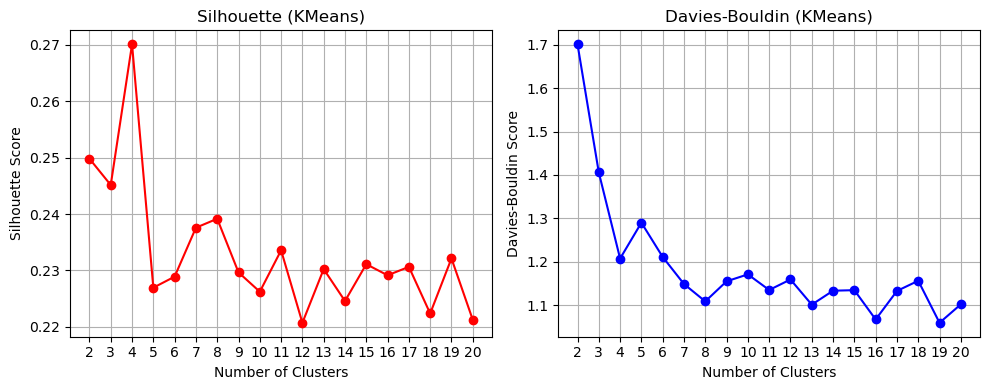

In [37]:
# Optional Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Silhouette scores plot
plt.grid()
axes[0].plot(number_of_clusters, silhouette_list, marker="o", color="red")
axes[0].set_title("Silhouette (KMeans)")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_xticks(number_of_clusters)
axes[0].grid(True)


# Davies-Bouldin scores plot
plt.grid()
axes[1].plot(number_of_clusters, davies_bouldin_list, marker="o", color="blue")
axes[1].set_title("Davies-Bouldin (KMeans)", )
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Davies-Bouldin Score")
axes[1].set_xticks(number_of_clusters)
axes[1].grid(True)

# Adjust layout and display
plt.tight_layout()
plt.show()

Cluster labels: [0 0 0 ... 2 2 1]
Silhouette Score: 0.2392
Davies-Bouldin Score: 1.1086


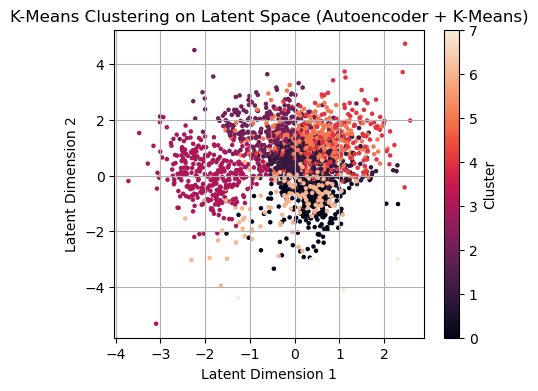

2131


In [40]:

# Step 9: Apply K-Means to the latent space
num_clusters = 8 # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters,  init='k-means++', n_init=10, random_state=42)
clusters_vect = kmeans.fit_predict(X_latent)

# Step 10: Optionally, you can visualize the clusters or perform further evaluation
print("Cluster labels:", clusters_vect)

# Step 11: Evaluate clustering performance
silhouette_avg = silhouette_score(X_latent, clusters_vect)
davies_bouldin = davies_bouldin_score(X_latent, clusters_vect)
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")


# Optional Visualization
plt.figure(figsize=(5, 4))
plt.scatter(X_latent[:, 0], X_latent[:,2], c=clusters_vect, cmap='rocket', s=5)
plt.title("K-Means Clustering on Latent Space (Autoencoder + K-Means)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

print(len(clusters_vect))

## Visualizing types

In [47]:
Covariates_trans_df = scaled_processed_transformed_df.copy()
Covariates_trans_df["type"] = clusters_vect
Covariates_df["municipality_type"] = clusters_vect

"""
Covariates_trans_df.columns =[
    'population',
    'yes_votes_for_climate_and_innovation_act',
    'no_votes_for_climate_and_innovation_act',
    'age_group_0_to_19',
    'age_group_20_to_64',
    'age_group_65_and_older',
    'number_of_private_households',
    'housing_and_infrastructure_area_percentage',
    'total_employment',
    'employment_in_primary_sector',
    'employment_in_secondary_sector',
    'employment_in_tertiary_sector',
    'new_housing_units_per_1000_inhabitants',
    'social_assistance_rate',
    'free_democratic_party',
    'christian_democratic_peoples_party',
    'social_democratic_party',
    'swiss_peoples_party',
    'evangelical_peoples_party_or_christian_social_party',
    'green_liberal_party',
    'conservative_democratic_party',
    'swiss_labour_party_or_solidarity',
    'ecologist_party',
    'small_right_wing_parties',
    'municipal_revenue_in_chf',
    'revenue_per_capita_in_chf',
    'electricity_consumption_by_households_in_mwh_per_year_per_capita',
    'electricity_consumption_by_households_in_mwh_per_year',
    'electricity_consumption_in_mwh_per_year_per_capita',
    'electricity_consumption_in_mwh_per_year',
    'average_electricity_price_in_cents_per_kwh',
    'standard_deviation_of_electricity_price_in_cents_per_kwh',
    'new_buildings_per_capita',
    'old_buildings_per_capita',
    'ancient_buildings_per_capita',
    'centrally_located_rural_municipality',
    'high_density_periurban_municipality',
    'low_density_periurban_municipality',
    'medium_density_periurban_municipality',
    'peripheral_rural_municipality',
    'rural_center_municipality',
    'urban_municipality_in_large_agglomeration',
    'urban_municipality_in_medium_sized_agglomeration',
    'urban_municipality_in_small_or_non_agglomerated_area',
    'region_alpes',
    'region_black_forest_or_jura_souabe',
    'region_jura',
    'region_middle_land_or_rhein',
    'region_non_mountainous',
    'language_french',
    'language_german',
    'language_italian',
    'language_romansh', 
    'municipality_type'
]
Covariates_df[Covariates_df["municipality_type"]==6]"""

'\nCovariates_trans_df.columns =[\n    \'population\',\n    \'yes_votes_for_climate_and_innovation_act\',\n    \'no_votes_for_climate_and_innovation_act\',\n    \'age_group_0_to_19\',\n    \'age_group_20_to_64\',\n    \'age_group_65_and_older\',\n    \'number_of_private_households\',\n    \'housing_and_infrastructure_area_percentage\',\n    \'total_employment\',\n    \'employment_in_primary_sector\',\n    \'employment_in_secondary_sector\',\n    \'employment_in_tertiary_sector\',\n    \'new_housing_units_per_1000_inhabitants\',\n    \'social_assistance_rate\',\n    \'free_democratic_party\',\n    \'christian_democratic_peoples_party\',\n    \'social_democratic_party\',\n    \'swiss_peoples_party\',\n    \'evangelical_peoples_party_or_christian_social_party\',\n    \'green_liberal_party\',\n    \'conservative_democratic_party\',\n    \'swiss_labour_party_or_solidarity\',\n    \'ecologist_party\',\n    \'small_right_wing_parties\',\n    \'municipal_revenue_in_chf\',\n    \'revenue_per_ca

In [49]:
typologies_df = Covariates_trans_df.groupby("type").mean()
typologies_df.mean()

Population                                                   2.201338
Yes [nbr]                                                    0.380996
No [nbr]                                                    -0.380996
0-19 years                                                  -0.247099
20-64 years                                                  0.167821
                                                               ...   
elec_network_operator_eug Elektra Untergäu Genossenschaft    0.001153
elec_network_operator_ewl Kabelnetz AG                       0.000953
elec_network_operator_genossenschaft elektra busslingen      0.000217
elec_network_operator_rwt Regionalwerk Toggenburg AG         0.000623
elec_network_operator_tba energie ag                         0.000217
Length: 560, dtype: float64

In [50]:
typologies_df_normalized = typologies_df.copy()
typologies_df_min_max = typologies_df.copy()

for col in typologies_df_normalized.columns:
    typologies_df_normalized[col] = (typologies_df_normalized[col]-typologies_df_normalized[col].mean())/typologies_df_normalized[col].std()
    typologies_df_min_max[col] = (typologies_df_min_max[col]-typologies_df_min_max[col].min())/(typologies_df_min_max[col].max()-typologies_df_min_max[col].min())


"""column_names = [
    'Population',
    'Yes Votes For Climate And Innovation Act',
    'No Votes For Climate And Innovation Act',
    'Age Group 0 To 19',
    'Age Group 20 To 64',
    'Age Group 65 And Older',
    'Number Of Private Households',
    'Housing And Infrastructure Area Percentage',
    'Total Employment',
    'Employment In Primary Sector',
    'Employment In Secondary Sector',
    'Employment In Tertiary Sector',
    'New Housing Units Per 1000 Inhabitants',
    'Social Assistance Rate',
    'Free Democratic Party',
    'Christian Democratic Peoples Party',
    'Social Democratic Party',
    'Swiss Peoples Party',
    'Evangelical Peoples Party Or Christian Social Party',
    'Green Liberal Party',
    'Conservative Democratic Party',
    'Swiss Labour Party Or Solidarity',
    'Ecologist Party',
    'Small Right Wing Parties',
    'Municipal Revenue In Chf',
    'Revenue Per Capita In Chf',
    'Electricity Consumption By Households In Mwh Per Year Per Capita',
    'Electricity Consumption By Households In Mwh Per Year',
    'Electricity Consumption In Mwh Per Year Per Capita',
    'Electricity Consumption In Mwh Per Year',
    'Average Electricity Price In Cents Per Kwh',
    'Standard Deviation Of Electricity Price In Cents Per Kwh',
    'New Buildings Per Capita',
    'Old Buildings Per Capita',
    'Ancient Buildings Per Capita',
    'Centrally Located Rural Municipality',
    'High Density Periurban Municipality',
    'Low Density Periurban Municipality',
    'Medium Density Periurban Municipality',
    'Peripheral Rural Municipality',
    'Rural Center Municipality',
    'Urban Municipality In Large Agglomeration',
    'Urban Municipality In Medium Sized Agglomeration',
    'Urban Municipality In Small Or Non Agglomerated Area',
    'Region Alpes',
    'Region Black Forest Or Jura Souabe',
    'Region Jura',
    'Region Middle Land Or Rhein',
    'Region Non Mountainous',
    'Language French',
    'Language German',
    'Language Italian',
    'Language Romansh'
]

typologies_df_normalized.columns = column_names
typologies_df_min_max.columns= column_names"""

"column_names = [\n    'Population',\n    'Yes Votes For Climate And Innovation Act',\n    'No Votes For Climate And Innovation Act',\n    'Age Group 0 To 19',\n    'Age Group 20 To 64',\n    'Age Group 65 And Older',\n    'Number Of Private Households',\n    'Housing And Infrastructure Area Percentage',\n    'Total Employment',\n    'Employment In Primary Sector',\n    'Employment In Secondary Sector',\n    'Employment In Tertiary Sector',\n    'New Housing Units Per 1000 Inhabitants',\n    'Social Assistance Rate',\n    'Free Democratic Party',\n    'Christian Democratic Peoples Party',\n    'Social Democratic Party',\n    'Swiss Peoples Party',\n    'Evangelical Peoples Party Or Christian Social Party',\n    'Green Liberal Party',\n    'Conservative Democratic Party',\n    'Swiss Labour Party Or Solidarity',\n    'Ecologist Party',\n    'Small Right Wing Parties',\n    'Municipal Revenue In Chf',\n    'Revenue Per Capita In Chf',\n    'Electricity Consumption By Households In Mwh Pe

In [51]:
"""reordered_columns = [
    # Population
    'Population',

    # Ages
    'Age Group 0 To 19',
    'Age Group 20 To 64',
    'Age Group 65 And Older',

    # Buildings
    'Number Of Private Households',
    'Housing And Infrastructure Area Percentage',
    'New Housing Units Per 1000 Inhabitants',
    'New Buildings Per Capita',
    'Old Buildings Per Capita',
    'Ancient Buildings Per Capita',

    # Economy
    'Total Employment',
    'Employment In Primary Sector',
    'Employment In Secondary Sector',
    'Employment In Tertiary Sector',
    'Social Assistance Rate',
    'Municipal Revenue In Chf',
    'Revenue Per Capita In Chf',

    # Political Parties
    'Yes Votes For Climate And Innovation Act',
    'No Votes For Climate And Innovation Act',
    'Free Democratic Party',
    'Christian Democratic Peoples Party',
    'Social Democratic Party',
    'Swiss Peoples Party',
    'Evangelical Peoples Party Or Christian Social Party',
    'Green Liberal Party',
    'Conservative Democratic Party',
    'Swiss Labour Party Or Solidarity',
    'Ecologist Party',
    'Small Right Wing Parties',

    # Electric Consumption
    'Electricity Consumption By Households In Mwh Per Year Per Capita',
    'Electricity Consumption By Households In Mwh Per Year',
    'Electricity Consumption In Mwh Per Year Per Capita',
    'Electricity Consumption In Mwh Per Year',
    'Average Electricity Price In Cents Per Kwh',
    'Standard Deviation Of Electricity Price In Cents Per Kwh',

    # Urban Types
    'Centrally Located Rural Municipality',
    'High Density Periurban Municipality',
    'Low Density Periurban Municipality',
    'Medium Density Periurban Municipality',
    'Peripheral Rural Municipality',
    'Rural Center Municipality',
    'Urban Municipality In Large Agglomeration',
    'Urban Municipality In Medium Sized Agglomeration',
    'Urban Municipality In Small Or Non Agglomerated Area',

    # Mountainous Types
    'Region Alpes',
    'Region Black Forest Or Jura Souabe',
    'Region Jura',
    'Region Middle Land Or Rhein',
    'Region Non Mountainous',

    # Languages
    'Language French',
    'Language German',
    'Language Italian',
    'Language Romansh'
]


typologies_df_min_max = typologies_df_min_max[reordered_columns]
typologies_df_normalized = typologies_df_normalized[reordered_columns]"""

"reordered_columns = [\n    # Population\n    'Population',\n\n    # Ages\n    'Age Group 0 To 19',\n    'Age Group 20 To 64',\n    'Age Group 65 And Older',\n\n    # Buildings\n    'Number Of Private Households',\n    'Housing And Infrastructure Area Percentage',\n    'New Housing Units Per 1000 Inhabitants',\n    'New Buildings Per Capita',\n    'Old Buildings Per Capita',\n    'Ancient Buildings Per Capita',\n\n    # Economy\n    'Total Employment',\n    'Employment In Primary Sector',\n    'Employment In Secondary Sector',\n    'Employment In Tertiary Sector',\n    'Social Assistance Rate',\n    'Municipal Revenue In Chf',\n    'Revenue Per Capita In Chf',\n\n    # Political Parties\n    'Yes Votes For Climate And Innovation Act',\n    'No Votes For Climate And Innovation Act',\n    'Free Democratic Party',\n    'Christian Democratic Peoples Party',\n    'Social Democratic Party',\n    'Swiss Peoples Party',\n    'Evangelical Peoples Party Or Christian Social Party',\n    'Green Li

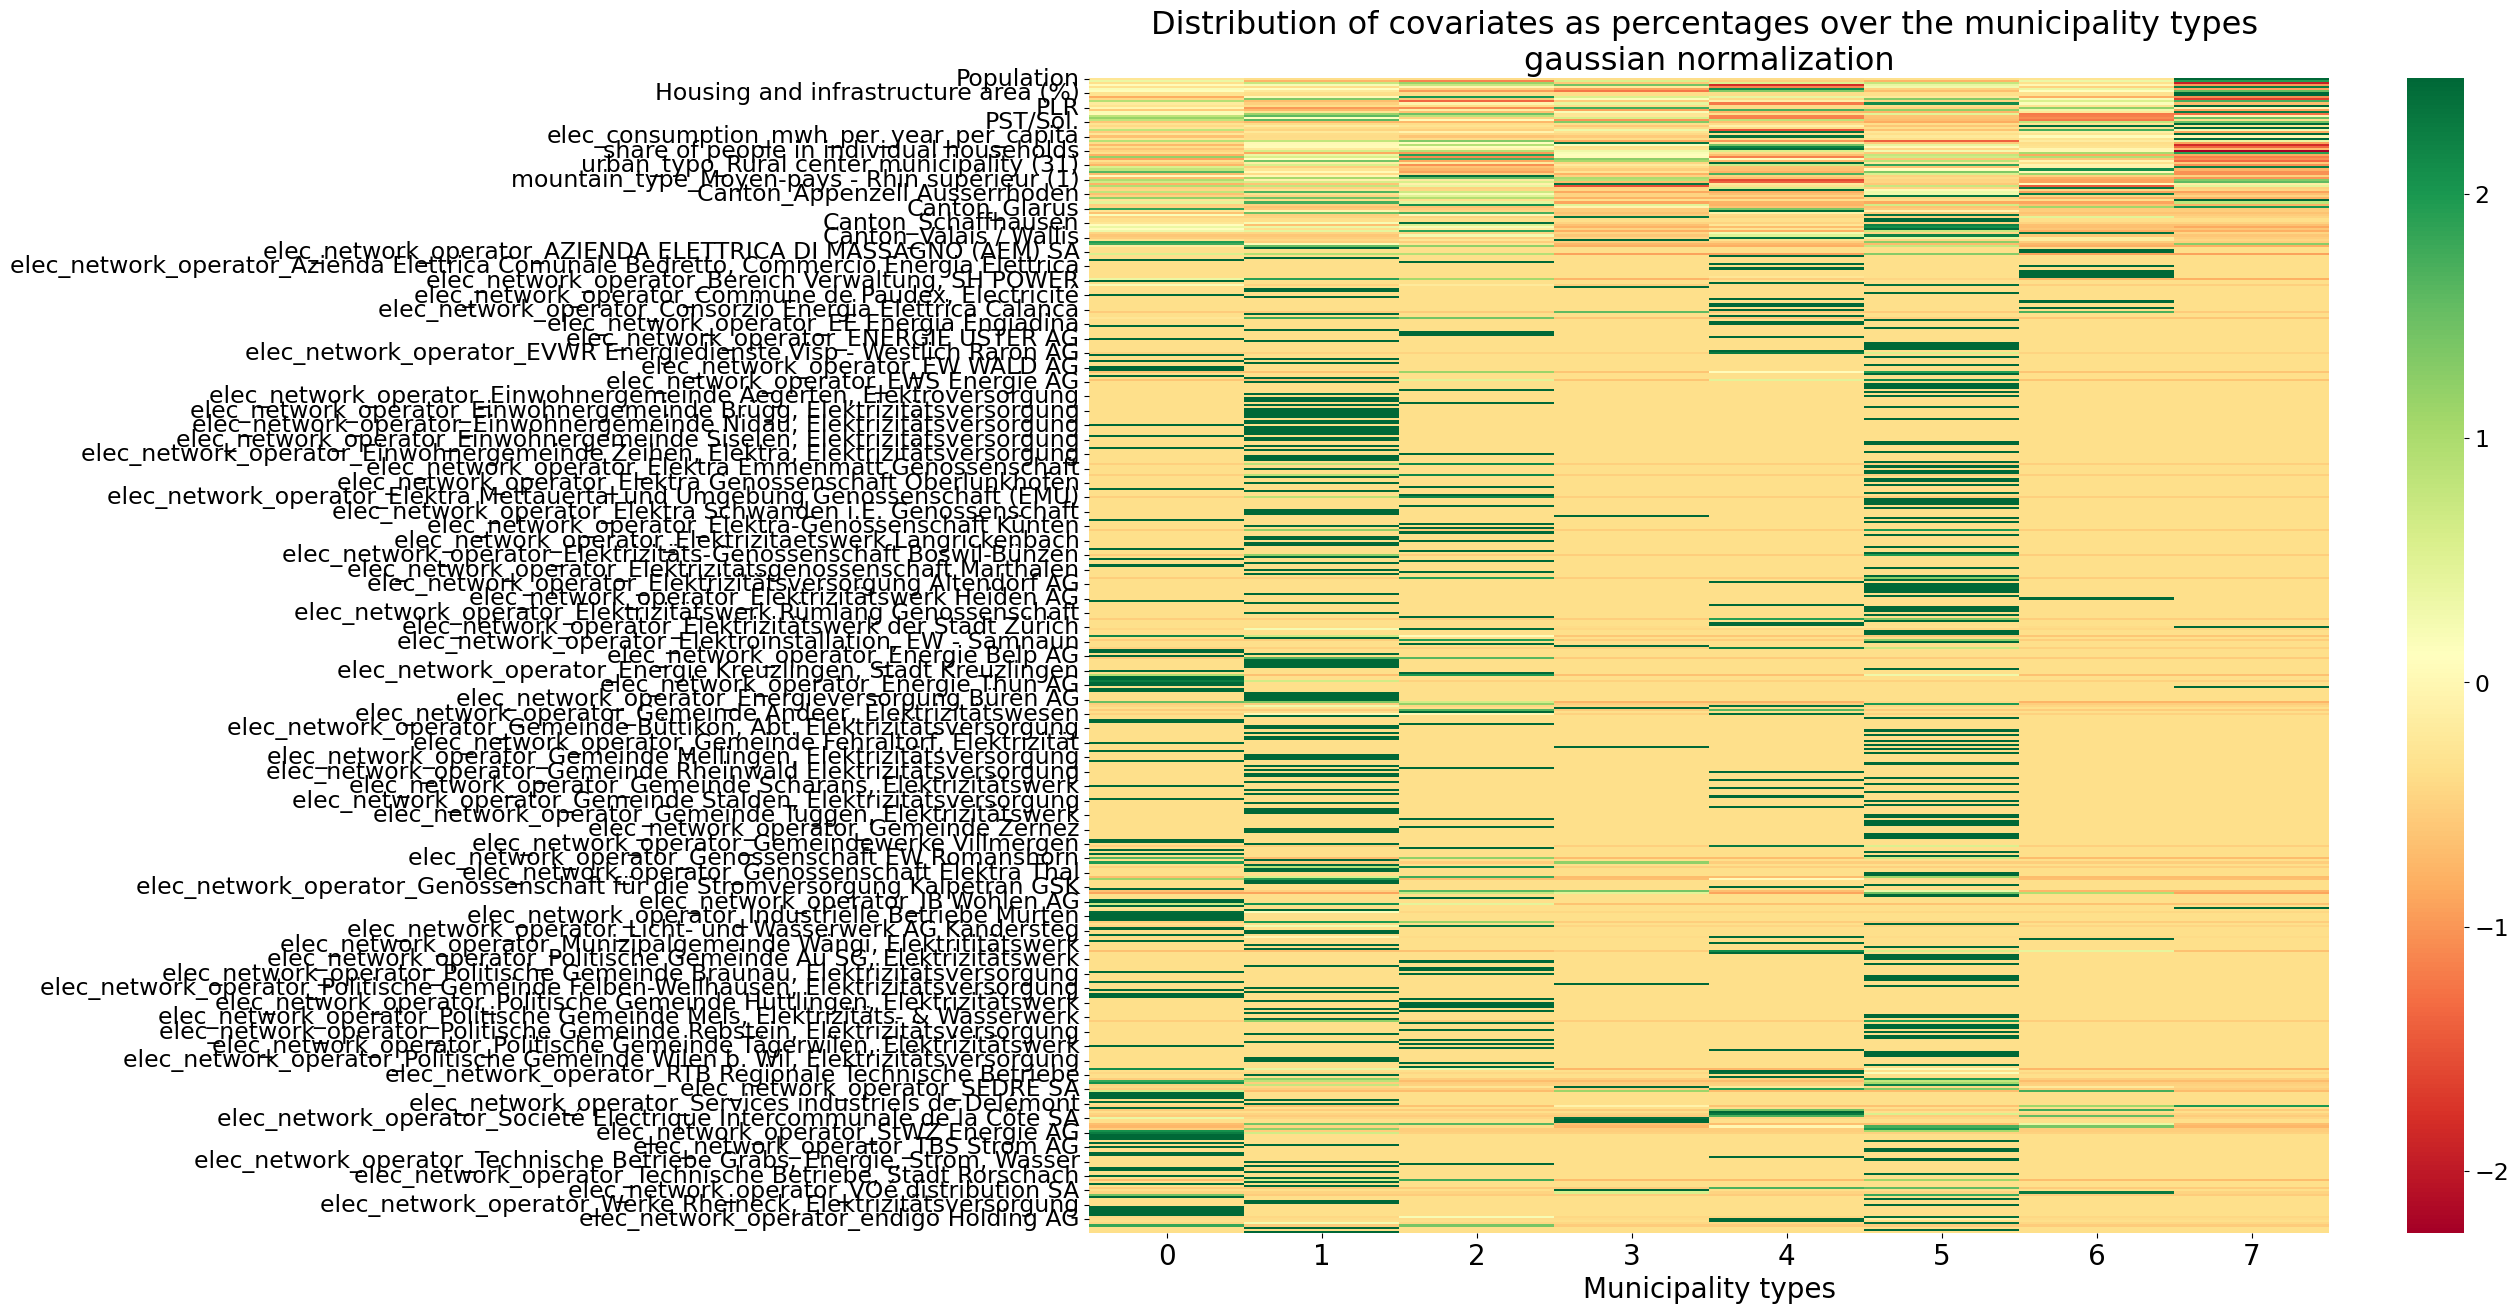

In [52]:
# Create a heatmap of the DataFrame
plt.figure(figsize=(20, 15))
ax = sns.heatmap(typologies_df_normalized.T, annot=False, fmt='g', cmap='RdYlGn', cbar=True)

# Increase the font size of the colorbar ticks
cbar = ax.collections[0].colorbar  # Access the colorbar
cbar.ax.tick_params(labelsize=17)  # Adjust size as needed

# Add labels and title
plt.title("Distribution of covariates as percentages over the municipality types \ngaussian normalization", size=23,)
plt.xlabel("Municipality types", size=20)
#plt.ylabel("Covariates")
plt.xticks(size=20)
plt.yticks(size=17)
plt.show()

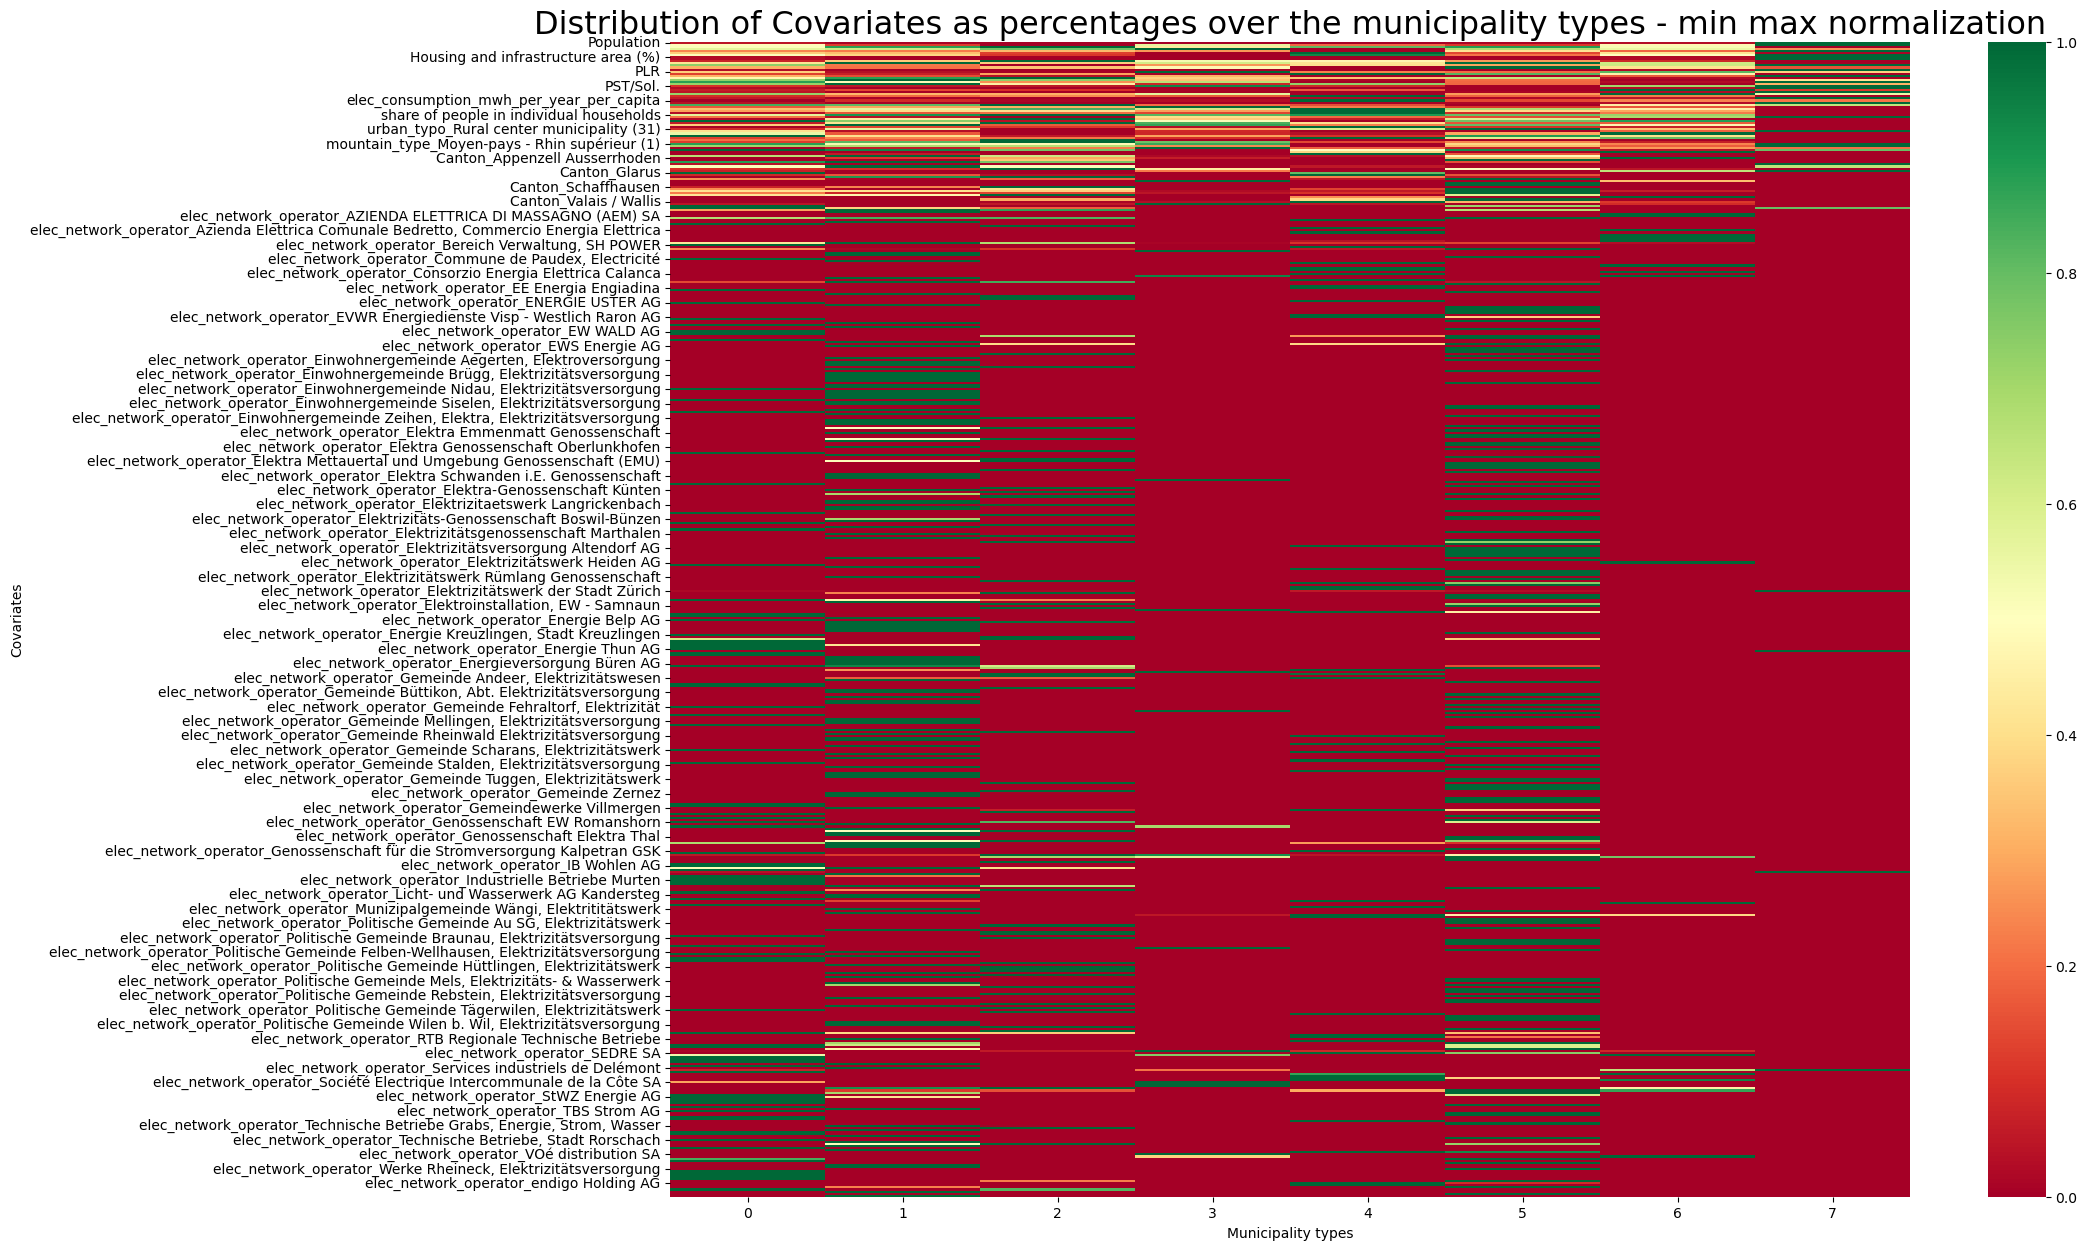

In [53]:
# Create a heatmap of the DataFrame
plt.figure(figsize=(20, 15))
sns.heatmap(typologies_df_min_max.T, annot=False, fmt='g', cmap='RdYlGn', cbar=True)

# Add labels and title
plt.title("Distribution of Covariates as percentages over the municipality types - min max normalization", size=23)
plt.xlabel("Municipality types")
plt.ylabel("Covariates")
plt.show()

In [54]:
Covariates_trans_df

Population  Yes [nbr]  No [nbr]  0-19 years  20-64 years  \
0      -0.164167   0.489165 -0.489165   -0.207587     0.645798   
1       0.647875   0.743894 -0.743894   -0.094790     0.480800   
2       0.110975   1.002930 -1.002930    0.941221    -0.097560   
3      -0.016428   0.569783 -0.569783    0.506756    -0.100980   
4      -0.017250   0.597685 -0.597685    0.340900     0.474013   
...          ...        ...       ...         ...          ...   
2126   -0.216803   1.439041 -1.439041   -0.654864    -1.114707   
2127   -0.234522   0.823919 -0.823919   -0.804663    -1.470423   
2128   -0.228765  -0.056895  0.056895    0.263525    -1.929783   
2129   -0.286410   0.082770 -0.082770   -0.160832    -2.108187   
2130   -0.256205  -0.470105  0.470105   -1.728238    -2.277539   

      65 years or older  Private households  \
0             -0.307013            0.314385   
1             -0.274049            0.237145   
2             -0.645999           -0.003046   
3             -0.312920           -0.422508   
4             -0.600710           -0.245290   
...                 ...                 ...   
2126           1.300934            0.915934   
2127           1.671047            1.453821   
2128           1.188930            0.615510   
2129           1.640306            0.609963   
2130           2.954994            2.113812   

      Housing and infrastructure area (%)  Total employment  Primary sector  \
0                               -0.120694         -0.150143       -0.427424   
1                                0.304738          0.318395       -0.925601   
2                               -0.046973         -0.108772       -0.762045   
3                               -0.093483         -0.108265       -0.409980   
4                               -0.060566         -0.075212       -0.847127   
...                                   ...               ...             ...   
2126                            -0.145444         -0.135460        0.976970   
2127                            -0.145662         -0.125552        0.096654   
2128                            -0.144153         -0.153470        0.608407   
2129                            -0.148536         -0.178423        1.634274   
2130                            -0.144816         -0.158388        0.123968   

      ...  elec_network_operator_die werke versorgung wallisellen ag  \
0     ...                                                  0           
1     ...                                                  0           
2     ...                                                  0           
3     ...                                                  0           
4     ...                                                  0           
...   ...                                                ...           
2126  ...                                                  0           
2127  ...                                                  0           
2128  ...                                                  0           
2129  ...                                                  0           
2130  ...                                                  0           

      elec_network_operator_ebs Energie AG  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
...                                    ...   
2126                                     0   
2127                                     0   
2128                                     0   
2129                                     0   
2130                                     0   

      elec_network_operator_endigo Holding AG  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                   

In [44]:
Covariates_trans_df.to_csv("../../data/cleaned_data/Covariates_types.csv")

## Importing PV data

In [55]:
Swiss_solar_potential = pd.read_csv("../../data/cleaned_data/Swiss_solar_potential.csv")
Swiss_solar_potential

mun_name canton_abr        pv_pot   pv_pot_reco       fpv_pot  \
0             Sévaz         FR  4.670673e+06  4.180890e+06  1.929158e+06   
1       Onnens (VD)         VD  1.305776e+07  1.177943e+07  3.235058e+06   
2     Cressier (NE)         NE  1.679586e+07  1.422929e+07  7.305761e+06   
3          Clarmont         VD  1.777467e+06  1.489369e+06  9.465443e+05   
4          Giornico         TI  1.495146e+07  5.614214e+06  5.010771e+06   
...             ...        ...           ...           ...           ...   
2126         Eisten         VS  1.159662e+06  6.201025e+05  7.894920e+05   
2127   Zwischbergen         VS  9.111890e+05  1.736294e+05  6.840052e+05   
2128        Ferrera         GR  1.881119e+06  1.338627e+06  1.155161e+06   
2129      Rongellen         GR  6.321874e+05  2.848915e+05  2.847475e+05   
2130    Bosco/Gurin         TI  1.573302e+06  1.088195e+06  1.040593e+06   

      fpv_pot_reco      roof_area    facade_area  total_power  total_energy  \
0     1.425327e+06   39036.054397   33832.332298      3693.98     3693980.0   
1     2.103798e+06  112876.590943   63996.552432      8615.12     8615120.0   
2     4.541674e+06  146427.208998  153540.786324      9229.40     9229400.0   
3     6.455402e+05   13871.650234   16173.060807       986.84      986840.0   
4     2.016368e+06  150042.723782  137640.972544      3393.20     3393200.0   
...            ...            ...            ...          ...           ...   
2126  3.089211e+05   12376.176170   18211.712716         0.00           0.0   
2127  1.835165e+05   11167.439085   18390.274529         0.00           0.0   
2128  6.540965e+05   18165.699377   24885.535927         0.00           0.0   
2129  1.276220e+05    6435.525421    7305.033094         0.00           0.0   
2130  6.231462e+05   15738.040974   22894.051664         0.00           0.0   

      ...  Scenario3_RoofsFacades_PotentialSolarElectricity_Month08_GWh  \
0     ...                                               1.72              
1     ...                                               2.12              
2     ...                                               3.73              
3     ...                                               0.38              
4     ...                                               1.21              
...   ...                                                ...              
2126  ...                                               0.28              
2127  ...                                               0.20              
2128  ...                                               0.39              
2129  ...                                               0.08              
2130  ...                                               0.36              

      Scenario3_RoofsFacades_PotentialSolarElectricity_Month09_GWh  \
0                                                  1.35              
1                                                  1.67              
2                                                  2.97              
3                                                  0.32              
4                                                  0.99              
...                                                 ...              
2126                                               0.24              
2127                                               0.17              
2128                                               0.33              
2129                                               0.07              
2130                                               0.31              

      Scenario3_RoofsFacades_PotentialSolarElectricity_Month10_GWh  \
0                                                  0.87              
1                                                  1.02              
2                                                  1.86              
3                                                  0.21              
4                                                  0.66  

In [56]:
Swiss_solar_potential = Swiss_solar_potential.sort_values(by="mun_id", ascending=True)


In [57]:
Swiss_solar_potential["municipality_type"]=clusters_vect
Swiss_solar_potential[Swiss_solar_potential["municipality_type"]==6]

mun_name canton_abr        pv_pot   pv_pot_reco  \
294                     Bulle         FR  1.181134e+08  1.032669e+08   
1320  Feldbrunnen-St. Niklaus         SO  6.271515e+06  4.808620e+06   
626                      Gais         AR  3.495319e+07  2.392404e+07   
922                  Speicher         AR  3.146287e+07  2.140552e+07   
859               Teufen (AR)         AR  4.300833e+07  2.978347e+07   
...                       ...        ...           ...           ...   
1539          Pregny-Chambésy         GE  2.286168e+07  1.823183e+07   
145                   Satigny         GE  6.584819e+07  6.040253e+07   
1292                  Vernier         GE  1.065845e+08  9.706691e+07   
1805                  Versoix         GE  4.124641e+07  3.434692e+07   
1240                  Veyrier         GE  6.160706e+07  5.057431e+07   

           fpv_pot  fpv_pot_reco     roof_area   facade_area  total_power  \
294   7.116571e+07  4.827955e+07  1.032628e+06  1.271134e+06     19447.05   
1320  3.722766e+06  2.207081e+06  6.209803e+04  7.692196e+04       448.58   
626   1.968607e+07  1.214011e+07  3.433072e+05  3.944353e+05      3464.06   
922   1.940786e+07  1.154820e+07  3.108607e+05  4.053303e+05      2657.76   
859   2.702609e+07  1.671257e+07  4.338286e+05  5.515241e+05      3879.56   
...            ...           ...           ...           ...          ...   
1539  1.078495e+07  5.704074e+06  2.149621e+05  2.630266e+05      1322.07   
145   2.324505e+07  1.465220e+07  5.551111e+05  4.514147e+05     12153.73   
1292  5.655918e+07  3.285815e+07  9.438919e+05  1.190674e+06      8437.45   
1805  2.278482e+07  1.129292e+07  3.826730e+05  5.298361e+05      1932.92   
1240  2.314069e+07  1.223855e+07  5.320531e+05  5.530089e+05      4226.24   

      total_energy  ...  \
294     19447050.0  ...   
1320      448580.0  ...   
626      3464060.0  ...   
922      2657760.0  ...   
859      3879560.0  ...   
...            ...  ...   
1539     1322070.0  ...   
145     12153730.0  ...   
1292     8437450.0  ...   
1805     1932920.0  ...   
1240     4226240.0  ...   

      Scenario3_RoofsFacades_PotentialSolarElectricity_Month09_GWh  \
294                                               20.22              
1320                                               0.84              
626                                                3.68              
922                                                3.60              
859                                                5.63              
...                                                 ...              
1539                                               3.15              
145                                               10.21              
1292                                              16.23              
1805                                               5.53              
1240                                               7.36              

      Scenario3_RoofsFacades_PotentialSolarElectricity_Month10_GWh  \
294                                               14.62              
1320                                               0.56              
626                                                2.71              
922                                                2.48              
859                                                3.96              
...                                                 ...              
1539                                               1.98              
145                                                6.51              
1292                                              10.27              
1805                                               3.50              
1240                                               4.64              

      Scenario3_RoofsFacades_PotentialSolarElectricity_Month11_GWh  \
294                                                8.92              
1320                                               0.32              
626           

In [58]:
Swiss_solar_potential.columns

Index(['mun_name', 'canton_abr', 'pv_pot', 'pv_pot_reco', 'fpv_pot',
       'fpv_pot_reco', 'roof_area', 'facade_area', 'total_power',
       'total_energy', 'initial_power', 'total_potential',
       'recommended_potential', 'achieved_rp', 'achieved_tp', 'Canton',
       'Country', 'Scenario1_RoofsOnly_PotentialSolarElectricity_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month01_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month02_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month03_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month04_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month05_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month06_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month07_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month08_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectricity_Month09_GWh',
       'Scenario1_RoofsOnly_PotentialSolarElectrici

In [59]:
Swiss_solar_potential["achieved_rp"].median()

0.0745356492374057

In [60]:
pv_typologies_df = Swiss_solar_potential.groupby("municipality_type")["achieved_rp"].agg(["median", "mean", "std"])
pv_typologies_df

median      mean       std
municipality_type                              
0                  0.072076  0.076634  0.031961
1                  0.075684  0.083728  0.041966
2                  0.079768  0.087477  0.048992
3                  0.072369  0.084305  0.063829
4                  0.029234  0.032314  0.022575
5                  0.098561  0.109705  0.063940
6                  0.062675  0.072526  0.050072
7                  0.043552  0.041009  0.016053

In [61]:
Swiss_solar_potential[Swiss_solar_potential.municipality_type==6]["achieved_rp"]

294     0.128324
1320    0.063939
626     0.096053
922     0.080651
859     0.083438
          ...   
1539    0.055234
145     0.161932
1292    0.064941
1805    0.042352
1240    0.067283
Name: achieved_rp, Length: 129, dtype: float64

In [62]:
Swiss_solar_potential["municipality_type"].value_counts()

municipality_type
1    575
5    401
3    343
2    291
0    239
4    149
6    129
7      4
Name: count, dtype: int64

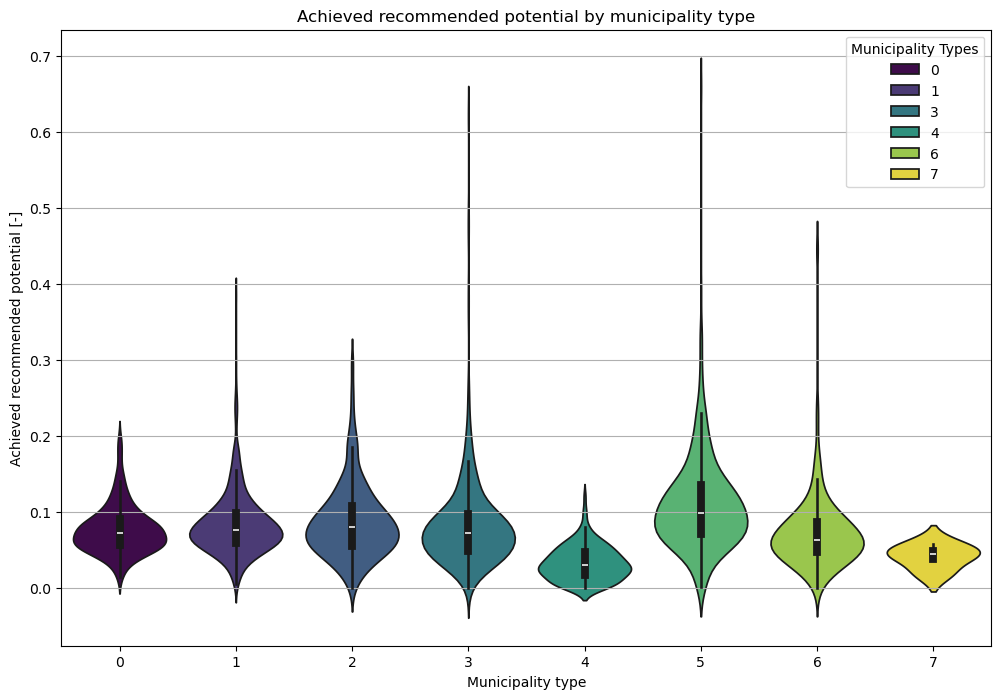

In [63]:
#Swiss_solar_potential.boxplot(column="achieved_rp", by="type", grid=False, figsize=(10, 6))

plt.figure(figsize=(12,8))
sns.violinplot(x="municipality_type", y="achieved_rp", hue="municipality_type", data=Swiss_solar_potential, palette="viridis")
plt.title("Achieved recommended potential by municipality type")
plt.xlabel("Municipality type")
plt.ylabel("Achieved recommended potential [-]")
plt.legend(title="Municipality Types")
plt.grid(axis="y")
plt.show()

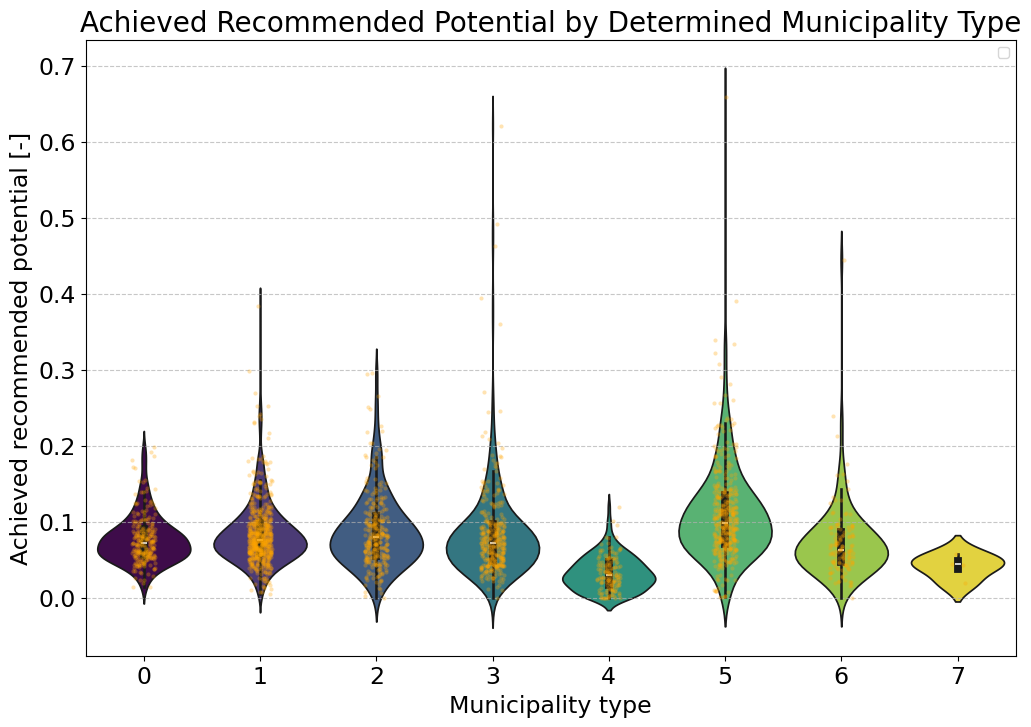

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming Swiss_solar_potential DataFrame is already defined

plt.figure(figsize=(12, 8))

# Create the violin plot
sns.violinplot(x="municipality_type", y="achieved_rp", hue="municipality_type", data=Swiss_solar_potential, palette="viridis")

# Overlay the swarmplot for individual data points
#sns.swarmplot(x="type", y="achieved_rp", data=Swiss_solar_potential, color="black", size=3, alpha=0.7)
sns.stripplot(x="municipality_type", y="achieved_rp", data=Swiss_solar_potential, color="orange", size=3, alpha=0.3, jitter=True)


# Title and labels
plt.title("Achieved Recommended Potential by Determined Municipality Type", fontsize=20)
plt.xlabel("Municipality type", fontsize=17)
plt.ylabel("Achieved recommended potential [-]", fontsize=17)

# Add grid
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend([])
plt.xticks(size=17)
plt.yticks(size=17)

# Display the plot
plt.show()


In [65]:

# Get the top 10 largest values for each category
top_10_per_category = Swiss_solar_potential.groupby("municipality_type")[["municipality_type", "achieved_rp", "mun_id"]].apply(lambda x: x.nlargest(10, 'achieved_rp')).reset_index(drop=True)

print("\nTop 10 largest values for each category:")
print(top_10_per_category)



Top 10 largest values for each category:
    municipality_type  achieved_rp  mun_id
0                   0     0.197816    4421
1                   0     0.191462    1095
2                   0     0.186915    1040
3                   0     0.180709       7
4                   0     0.171875    3955
..                ...          ...     ...
69                  6     0.128324    2125
70                  7     0.057787    2701
71                  7     0.044084     261
72                  7     0.043020     351
73                  7     0.019144    6621

[74 rows x 3 columns]


In [66]:
average_std_top_10 = top_10_per_category.groupby("municipality_type")["achieved_rp"].agg(["mean", "std"]).reset_index()
average_std_top_10

municipality_type      mean       std
0                  0  0.170396  0.018653
1                  1  0.263199  0.047433
2                  2  0.242443  0.034258
3                  3  0.351942  0.138398
4                  4  0.082933  0.017285
5                  5  0.345094  0.116952
6                  6  0.195454  0.094226
7                  7  0.041009  0.016053

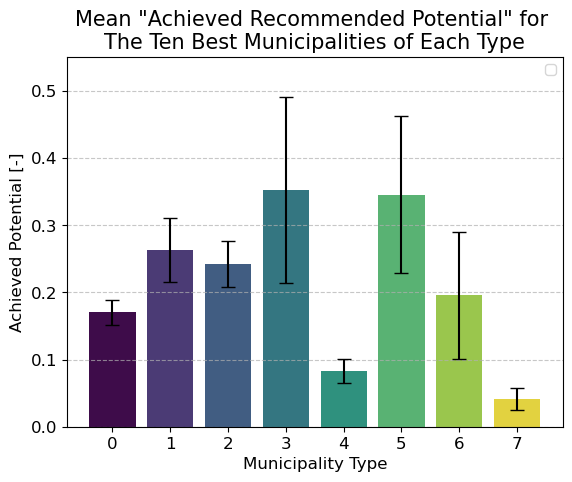

In [67]:
# Create the bar plot without the error bars
sns.barplot(
    x="municipality_type",
    y="mean",
    data=average_std_top_10,
    hue='municipality_type',
    palette="viridis"

)

# Add error bars using plt.errorbar
plt.errorbar(
    x=range(len(average_std_top_10)),
    y=average_std_top_10["mean"],
    yerr=average_std_top_10["std"],
    fmt='none',  # No markers, just error bars
    color='black',
    capsize=5
)

# Customizing the plot
plt.grid(axis="y", linestyle='--', alpha=0.7)
plt.title("Mean \"Achieved Recommended Potential\" for \nThe Ten Best Municipalities of Each Type", size=15)
plt.ylabel("Achieved Potential [-]", size=12)
plt.xlabel("Municipality Type", size=12)
plt.xticks(ticks=range(len(average_std_top_10)), labels=average_std_top_10["municipality_type"], rotation=0, size=12)
plt.yticks(size=12)
plt.ylim([0,0.55])
plt.legend([])
plt.show()


In [68]:
Reccommende_potential = Swiss_solar_potential[Swiss_solar_potential.mun_id.isin(top_10_per_category.mun_id)][["recommended_potential", "municipality_type"]]


In [69]:
average_std_top_10_reco = Reccommende_potential.groupby("municipality_type")["recommended_potential"].agg(["mean", "std"]).reset_index()
average_std_top_10_reco

municipality_type          mean           std
0                  0  4.347577e+07  3.255089e+07
1                  1  1.437357e+07  1.020740e+07
2                  2  8.050337e+06  7.713945e+06
3                  3  1.693168e+07  2.073016e+07
4                  4  2.041356e+07  2.020279e+07
5                  5  2.372413e+07  1.566129e+07
6                  6  4.407093e+07  4.379157e+07
7                  7  7.064167e+08  3.432471e+08

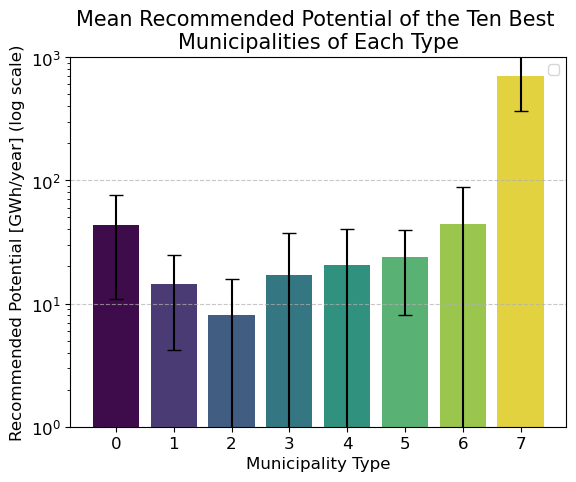

In [70]:
# Create the bar plot without the error bars
sns.barplot(
    x="municipality_type",
    y="mean",
    data=average_std_top_10_reco/(10**6),
    hue='municipality_type',
    palette="viridis"

)

# Add error bars using plt.errorbar
plt.errorbar(
    x=range(len(average_std_top_10_reco)),
    y=average_std_top_10_reco["mean"]/(10**6),
    yerr=average_std_top_10_reco["std"]/(10**6),
    fmt='none',  # No markers, just error bars
    color='black',
    capsize=5
)

# Customizing the plot
plt.grid(axis="y", linestyle='--', alpha=0.7)
plt.title("Mean Recommended Potential of the Ten Best \nMunicipalities of Each Type", size=15)
plt.ylabel("Recommended Potential [GWh/year] (log scale)", size=12)
plt.xlabel("Municipality Type", size=12)
plt.xticks(ticks=range(len(average_std_top_10_reco)), labels=average_std_top_10_reco["municipality_type"], rotation=0, size=12)
plt.yticks(size=12)
plt.ylim([1,1000])
plt.legend([])
plt.yscale("log")
plt.show()


In [71]:

# Get the top 10 smallest values for each category
low_10_per_category = Swiss_solar_potential.groupby("municipality_type")[["municipality_type", "achieved_rp", "mun_id"]].apply(lambda x: x.nsmallest(10, 'achieved_rp')).reset_index(drop=True)

print("\nTop 10 smallest values for each category:")
print(low_10_per_category)



Top 10 smallest values for each category:
    municipality_type  achieved_rp  mun_id
0                   0     0.013566    3786
1                   0     0.014379     245
2                   0     0.019444     249
3                   0     0.022926    6636
4                   0     0.023038    3851
..                ...          ...     ...
69                  6     0.026377    5146
70                  7     0.019144    6621
71                  7     0.043020     351
72                  7     0.044084     261
73                  7     0.057787    2701

[74 rows x 3 columns]


In [72]:
average_std_low_10 = low_10_per_category.groupby("municipality_type")["achieved_rp"].agg(["mean", "std"]).reset_index()
average_std_low_10

municipality_type      mean       std
0                  0  0.024508  0.007165
1                  1  0.011465  0.004358
2                  2  0.011466  0.007414
3                  3  0.016066  0.007717
4                  4  0.000130  0.000277
5                  5  0.006170  0.004190
6                  6  0.018339  0.007185
7                  7  0.041009  0.016053

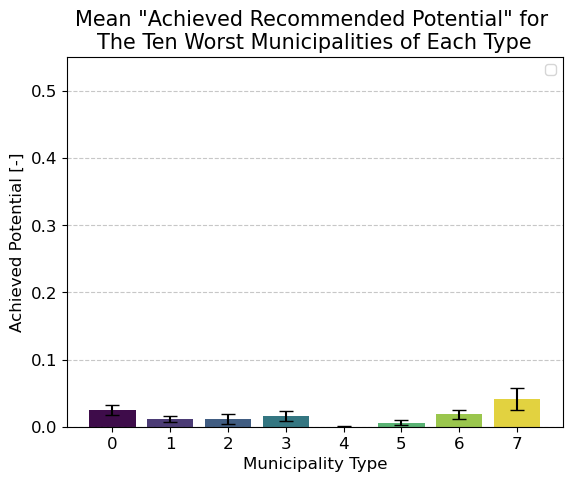

In [73]:
# Create the bar plot without the error bars
sns.barplot(
    x="municipality_type",
    y="mean",
    data=average_std_low_10,
    hue='municipality_type',
    palette="viridis"

)

# Add error bars using plt.errorbar
plt.errorbar(
    x=range(len(average_std_top_10)),
    y=average_std_low_10["mean"],
    yerr=average_std_low_10["std"],
    fmt='none',  # No markers, just error bars
    color='black',
    capsize=5
)

# Customizing the plot
plt.grid(axis="y", linestyle='--', alpha=0.7)
plt.title("Mean \"Achieved Recommended Potential\" for \nThe Ten Worst Municipalities of Each Type", size=15)
plt.ylabel("Achieved Potential [-]", size=12)
plt.xlabel("Municipality Type", size=12)
plt.yticks(size=12)
plt.xticks(ticks=range(len(average_std_low_10)), labels=average_std_low_10["municipality_type"], rotation=0, size=12)
plt.ylim([0,0.55])
plt.legend([])
plt.show()

In [64]:
Recommended_potential_low = Swiss_solar_potential[Swiss_solar_potential.mun_id.isin(low_10_per_category.mun_id)][["recommended_potential", "municipality_type"]]


In [65]:
average_std_low_10_reco = Recommended_potential_low.groupby("municipality_type")["recommended_potential"].agg(["mean", "std"]).reset_index()
average_std_low_10_reco

municipality_type          mean           std
0                  0  2.840255e+07  2.375123e+07
1                  1  2.262114e+07  1.945286e+07
2                  2  6.868598e+06  7.157236e+06
3                  3  8.584315e+06  1.139161e+07
4                  4  8.696186e+06  1.191450e+07
5                  5  7.148252e+06  1.017513e+07
6                  6  6.576724e+08  3.166133e+08
7                  7  1.385790e+07  9.392576e+06

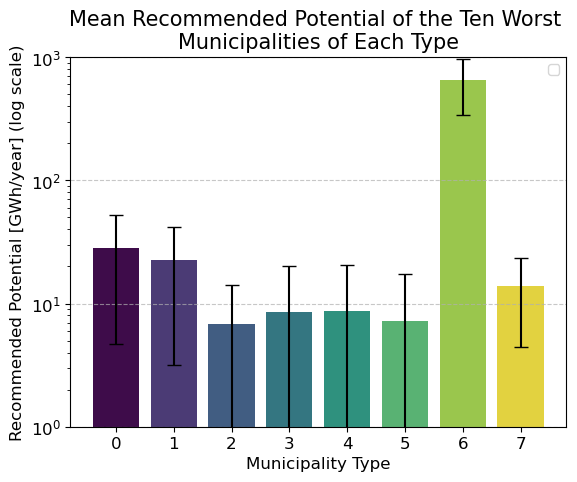

In [135]:
# Create the bar plot without the error bars
sns.barplot(
    x="municipality_type",
    y="mean",
    data=average_std_low_10_reco/(10**6),
    hue='municipality_type',
    palette="viridis"

)

# Add error bars using plt.errorbar
plt.errorbar(
    x=range(len(average_std_low_10_reco)),
    y=average_std_low_10_reco["mean"]/(10**6),
    yerr=average_std_low_10_reco["std"]/(10**6),
    fmt='none',  # No markers, just error bars
    color='black',
    capsize=5
)

# Customizing the plot
plt.grid(axis="y", linestyle='--', alpha=0.7, which="major")
plt.title("Mean Recommended Potential of the Ten Worst \nMunicipalities of Each Type", size=15)
plt.ylabel("Recommended Potential [GWh/year] (log scale)", size=12)
plt.xlabel("Municipality Type", size=12)
plt.xticks(ticks=range(len(average_std_low_10_reco)), labels=average_std_low_10_reco["municipality_type"], rotation=0, size=12)
plt.yticks(size=12)
#plt.ylim([0,0.55])
plt.legend([])
#plt.ylim([0,2*10**8])
plt.yscale("log")
plt.ylim([1, 1000])
plt.show()


In [ ]:
#Total swiss current production in TWh/year
Swiss_solar_potential["total_energy"].sum()/10**9

4.93541084

## updating dataframe 

In [67]:
df_to_add = Covariates_df[["MunicipalityNumber","urban_typo"]]

In [68]:
Swiss_solar_potential_final = pd.merge(Swiss_solar_potential, df_to_add, left_on="mun_id", right_on="MunicipalityNumber")

In [69]:
Swiss_solar_potential_final.drop(columns=["MunicipalityNumber"], inplace=True)

In [70]:
Swiss_solar_potential_final.to_csv("../../data/cleaned_data/Municipal_solar_types.csv")

In [71]:
Swiss_solar_potential_final[Swiss_solar_potential_final.municipality_type==6]

mun_name canton_abr        pv_pot   pv_pot_reco       fpv_pot  \
151     Zürich         ZH  1.173020e+09  8.256447e+08  8.140466e+08   
191       Bern         BE  5.606095e+08  4.128140e+08  3.271737e+08   
888      Basel         BS  5.848140e+08  4.261760e+08  3.332382e+08   
1692  Lausanne         VD  3.734897e+08  3.137341e+08  2.650313e+08   
2056    Genève         GE  4.012565e+08  3.320554e+08  2.521632e+08   

      fpv_pot_reco     roof_area   facade_area  total_power  total_energy  \
151   3.866836e+08  1.288725e+07  1.990452e+07     53443.86    53443860.0   
191   1.716060e+08  5.427322e+06  7.513526e+06     25141.86    25141860.0   
888   1.551066e+08  5.866243e+06  8.150225e+06     33590.46    33590460.0   
1692  1.489611e+08  3.465463e+06  5.836569e+06     17498.35    17498350.0   
2056  1.155805e+08  3.848463e+06  6.174442e+06      8569.50     8569500.0   

      ...  Scenario3_RoofsFacades_PotentialSolarElectricity_Month10_GWh  \
151   ...                                              93.85              
191   ...                                              48.06              
888   ...                                              46.87              
1692  ...                                              37.86              
2056  ...                                              32.66              

      Scenario3_RoofsFacades_PotentialSolarElectricity_Month11_GWh  \
151                                               48.25              
191                                               27.76              
888                                               25.03              
1692                                              22.52              
2056                                              17.94              

      Scenario3_RoofsFacades_PotentialSolarElectricity_Month12_GWh  \
151                                               36.15              
191                                               20.55              
888                                               18.80              
1692                                              16.84              
2056                                              12.95              

      Scenario4_RoofsFacades_PotentialSolarElectricity_GWh  \
151                                             1130.25      
191                                              604.66      
888                                              533.90      
1692                                             465.08      
2056                                             438.78      

      Scenario4_RoofsFacades_PotentialSolarHeat_GWh  \
151                                          456.94   
191                                          144.15   
888                                          176.28   
1692                                         125.01   
2056                                         105.49   

                                              Factsheet  \
151   https://www.uvek-gis.admin.ch/BFE/storymaps/EC...   
191   https://www.uvek-gis.admin.ch/BFE/storymaps/EC...   
888   https://www.uvek-gis.admin.ch/BFE/storymaps/EC...   
1692  https://www.uvek-gis.admin.ch/BFE/storymaps/EC...   
2056  https://www.uvek-gis.admin.ch/BFE/storymaps/EC...   

                                            Methodology  mun_id  \
151   https://www.uvek-gis.admin.ch/BFE/redirect/sol...     261   
191   https://www.uvek-gis.admin.ch/BFE/redirect/sol...     351   
888   https://www.uvek-gis.admin.ch/BFE/redirect/sol...    2701   
1692  https://www.uvek-gis.admin.ch/BFE/redirect/sol...    5586   
2056  https://www.uvek-gis.admin.ch/BFE/redirect/sol...    6621   

      municipality_type                                        urban_typo  
151                   6  Urban municipality in a large agglomeration (11)  
191                   6  Urban municipality in a large agglomeration (11)  
888                   6  Urban municipality in a large agglomeration (11)  
1692                  6  Urban municipality in a large ag